# Solving Hamilton-Jacobi PDEs via Time-Parameterized Deep Legendre Transform

## Problem Formulation

We consider the Cauchy problem for the Hamilton-Jacobi equation:

$$
\begin{cases}
\partial_t u + H(\nabla_x u(x, t)) = 0, & (x,t) \in \mathbb{R}^d \times (0, \infty) \\
u(x, 0) = g(x), & x \in \mathbb{R}^d
\end{cases}
$$

where $u: \mathbb{R}^d \times [0,\infty) \to \mathbb{R}$ is the value function, $H: \mathbb{R}^d \to \mathbb{R}$ is the Hamiltonian, and $g: \mathbb{R}^d \to \mathbb{R}$ is the initial condition.

## The Hopf Formula

Under appropriate convexity assumptions, the solution is given by the Hopf formula:

$$u(x, t) = (g^* + tH)^*(x) = \inf_{p \in \mathbb{R}^d} \{g^*(p) + tH(p) - \langle x, p \rangle\}$$

where $f^*$ denotes the convex conjugate (Legendre transform) of $f$.

## Methodology

### 1. Deep Galerkin Method (DGM)

The DGM approximates $u(x,t)$ with a neural network $u_\theta(x,t)$ by minimizing the PDE residual:

$$\mathcal{L}_{\text{DGM}} = \mathbb{E}_{(x,t)} \left[\left|\partial_t u_\theta + H(\nabla_x u_\theta)\right|^2\right] + \lambda \mathbb{E}_x \left[|u_\theta(x,0) - g(x)|^2\right]$$

### 2. Time-Parameterized Deep Legendre Transform (Time-DLT)

Our approach directly approximates the Hopf formula via:

$$F_\theta(x,t) \approx u(x,t) = \inf_p \{\langle x, p \rangle - g^*(p) - tH(p)\}$$

The key innovation is **time-parameterized inverse gradient sampling**. For cases where $p = \nabla u(x,t)$ cannot be computed analytically, we train a neural network $h_\phi(p,t): \mathbb{R}^d \times \mathbb{R}^+ \to \mathbb{R}^d$ that learns:

$$h_\phi(p,t) \approx x \quad \text{such that} \quad p = \nabla u(x,t)$$

The training objective for Time-DLT is:

$$\mathcal{L}_{\text{DLT}} = \mathbb{E}_{(x,p,t)} \left[|F_\theta(x,t) - (\langle x, p \rangle - g^*(p) - tH(p))|^2\right]$$

where $(x,p,t)$ are sampled using either analytical formulas (quadratic case) or the learned inverse network $h_\phi$.

## Experimental Setup

### Test Functions

We consider two classes of functions:

**1. Quadratic Functions**
- Initial condition: $g(x) = \frac{1}{2}\|x\|^2$
- Hamiltonian: $H(p) = \frac{1}{2}\|p\|^2$
- Conjugate: $g^*(p) = \frac{1}{2}\|p\|^2$
- Analytical solution: $u(x,t) = \frac{\|x\|^2}{2(1+t)}$

**2. Exponential Functions**
- Initial condition: $g(x) = \sum_{i=1}^d e^{x_i}$
- Hamiltonian: $H(p) = \sum_{i=1}^d e^{p_i}$
- Conjugate: $g^*(p) = \sum_{i=1}^d (p_i \log p_i - p_i)$ for $p_i > 0$

### Problem Configurations

- **Dimensions**: $d \in \{2, 5, 10\}$
- **Function combinations**:
  - Quadratic-Quadratic (baseline with known solution)
  - Quadratic-Exponential (mixed complexity)
  - Exponential-Quadratic (alternative mixed case)
- **Time horizons**: $t \in \{0.1, 0.5, 1.0, 2.0\}$
- **Domain**: $[-2, 2]^d$

### Neural Network Architecture

Both methods employ time-parameterized MLPs:
- Input: $(x, t) \in \mathbb{R}^d \times \mathbb{R}^+$
- Architecture: $d+1 \to 64 \to 64 \to 1$
- Activation: $\tanh$
- Optimizer: Adam with learning rate $10^{-3}$

For Time-DLT, the inverse gradient network $h_\phi$ uses:
- Input: $(p, t) \in \mathbb{R}^d \times \mathbb{R}^+$
- Architecture: $d+1 \to 64 \to 64 \to d$
- Two-phase training: 40% epochs for $h_\phi$, 60% for $F_\theta$

### Evaluation Metrics

1. **$L^2$ error against ground truth**: Computed via numerical optimization of the Hopf formula
2. **PDE residual**: $\|\partial_t u + H(\nabla_x u)\|_{L^2}$
3. **Initial condition error**: $\|u(\cdot, 0) - g\|_{L^2}$

### Implementation Details

- **Ground truth computation**:
  - Scipy L-BFGS-B for low dimensions ($d \leq 2$)
  - PyTorch gradient-based optimization for higher dimensions
- **Sampling strategy**: Adaptive mixing of initial condition and interior points
- **Batch size**: 100 samples per iteration
- **Training epochs**: 1500-3000 depending on dimension

## Running the Experiments

Execute the following to compare both methods:

```python
# Example: 2D exponential Hamiltonian
results = compare_methods_complete(
    dim=2,
    hamiltonian_type='exponential',
    ic_type='quadratic',
    t_values=[0.1, 0.5, 1.0],
    steps=1500,
    n_ground_truth_points=15
)
```

The notebook provides comprehensive visualizations including solution surfaces, error distributions, and sampling process illustrations for 2D problems.

Using device: cuda
HAMILTON-JACOBI EQUATION SOLVER
Comparing Deep Galerkin Method vs Proper Time-DLT

Test 1: 2D Exponential Hamiltonian

COMPLETE COMPARISON: DGM vs PROPER TIME-DLT
Problem: d=2, H=exponential, IC=quadratic

Initial memory state:
GPU Memory: Allocated=0.02GB, Reserved=0.02GB

------------------------------------------------------------
Training DGM...

TRAINING DEEP GALERKIN METHOD (DGM)
Dimension: 2, Hamiltonian: exponential, IC: quadratic


DGM Training: 100%|██████████| 20000/20000 [02:22<00:00, 140.46it/s, loss=0.218101]



Memory after DGM training:
GPU Memory: Allocated=0.02GB, Reserved=0.02GB

------------------------------------------------------------
Training Proper Time-DLT...

TRAINING PROPER TIME-DLT
Dimension: 2, Hamiltonian: exponential, IC: quadratic
Phase 1: Training gradient network h(x,t)...


Gradient Network Training: 100%|██████████| 8000/8000 [00:36<00:00, 221.08it/s, loss=0.020951]


Gradient network training complete. Final loss: 0.024988

Phase 2: Training main network u(x,t) using DLT...


Main Network Training (DLT): 100%|██████████| 12000/12000 [00:58<00:00, 203.73it/s, loss=0.000311]


Main network training complete. Final loss: 0.001535

Memory after DLT training:
GPU Memory: Allocated=0.02GB, Reserved=0.02GB


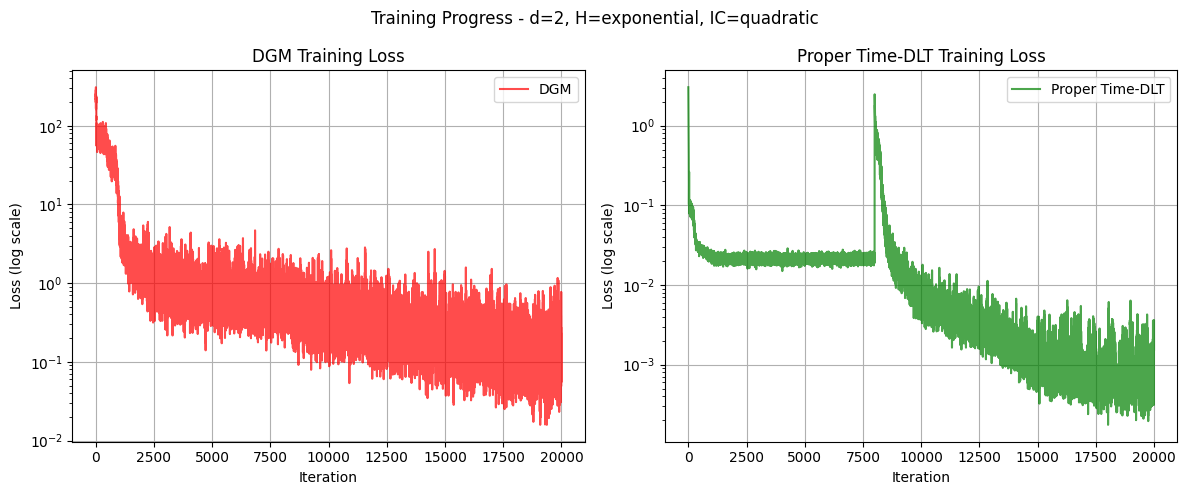


------------------------------------------------------------
Visualizing DLT sampling process...


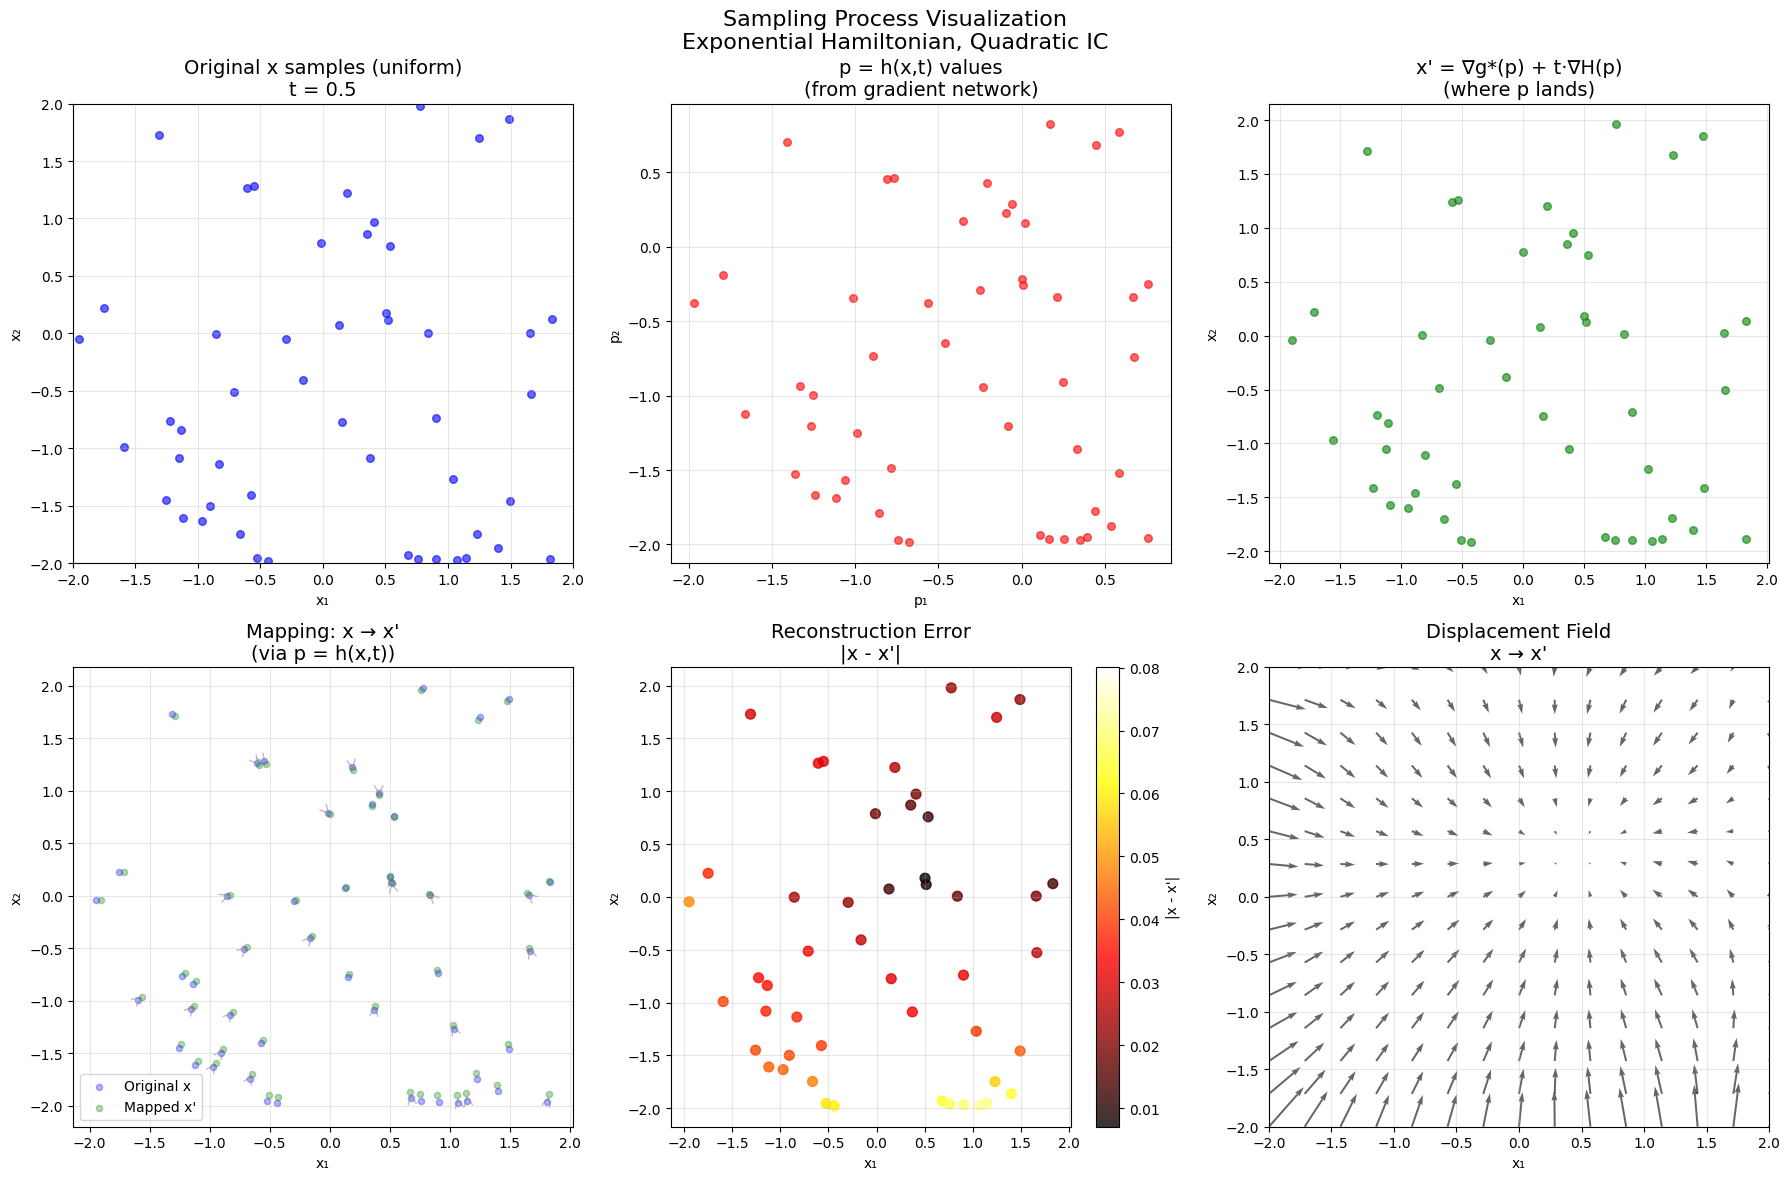


Sampling Statistics at t = 0.5:
Average reconstruction error |x - x'|: 0.036848
Max reconstruction error: 0.080102
Min reconstruction error: 0.007067

------------------------------------------------------------
Evaluating DGM with ground truth...

Evaluating at t = 0.1...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 464.81it/s]


L2 error (on subset): 1.459033e-01

Evaluating at t = 0.5...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 470.88it/s]


L2 error (on subset): 1.304128e+00

Evaluating at t = 1.0...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 461.00it/s]


L2 error (on subset): 3.246500e+00

Evaluating at t = 2.0...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 471.39it/s]

L2 error (on subset): 7.699204e+00



------------------------------------------------------------
Evaluating Proper Time-DLT with ground truth...

Evaluating at t = 0.1...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 462.04it/s]


L2 error (on subset): 6.879584e-02

Evaluating at t = 0.5...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 424.10it/s]


L2 error (on subset): 1.286055e+00

Evaluating at t = 1.0...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 450.45it/s]


L2 error (on subset): 3.210225e+00

Evaluating at t = 2.0...
Computing ground truth for 15 points...


Ground truth (scipy): 100%|██████████| 15/15 [00:00<00:00, 473.81it/s]

L2 error (on subset): 7.685212e+00



------------------------------------------------------------
Computing PDE residuals...

Visualizing results...


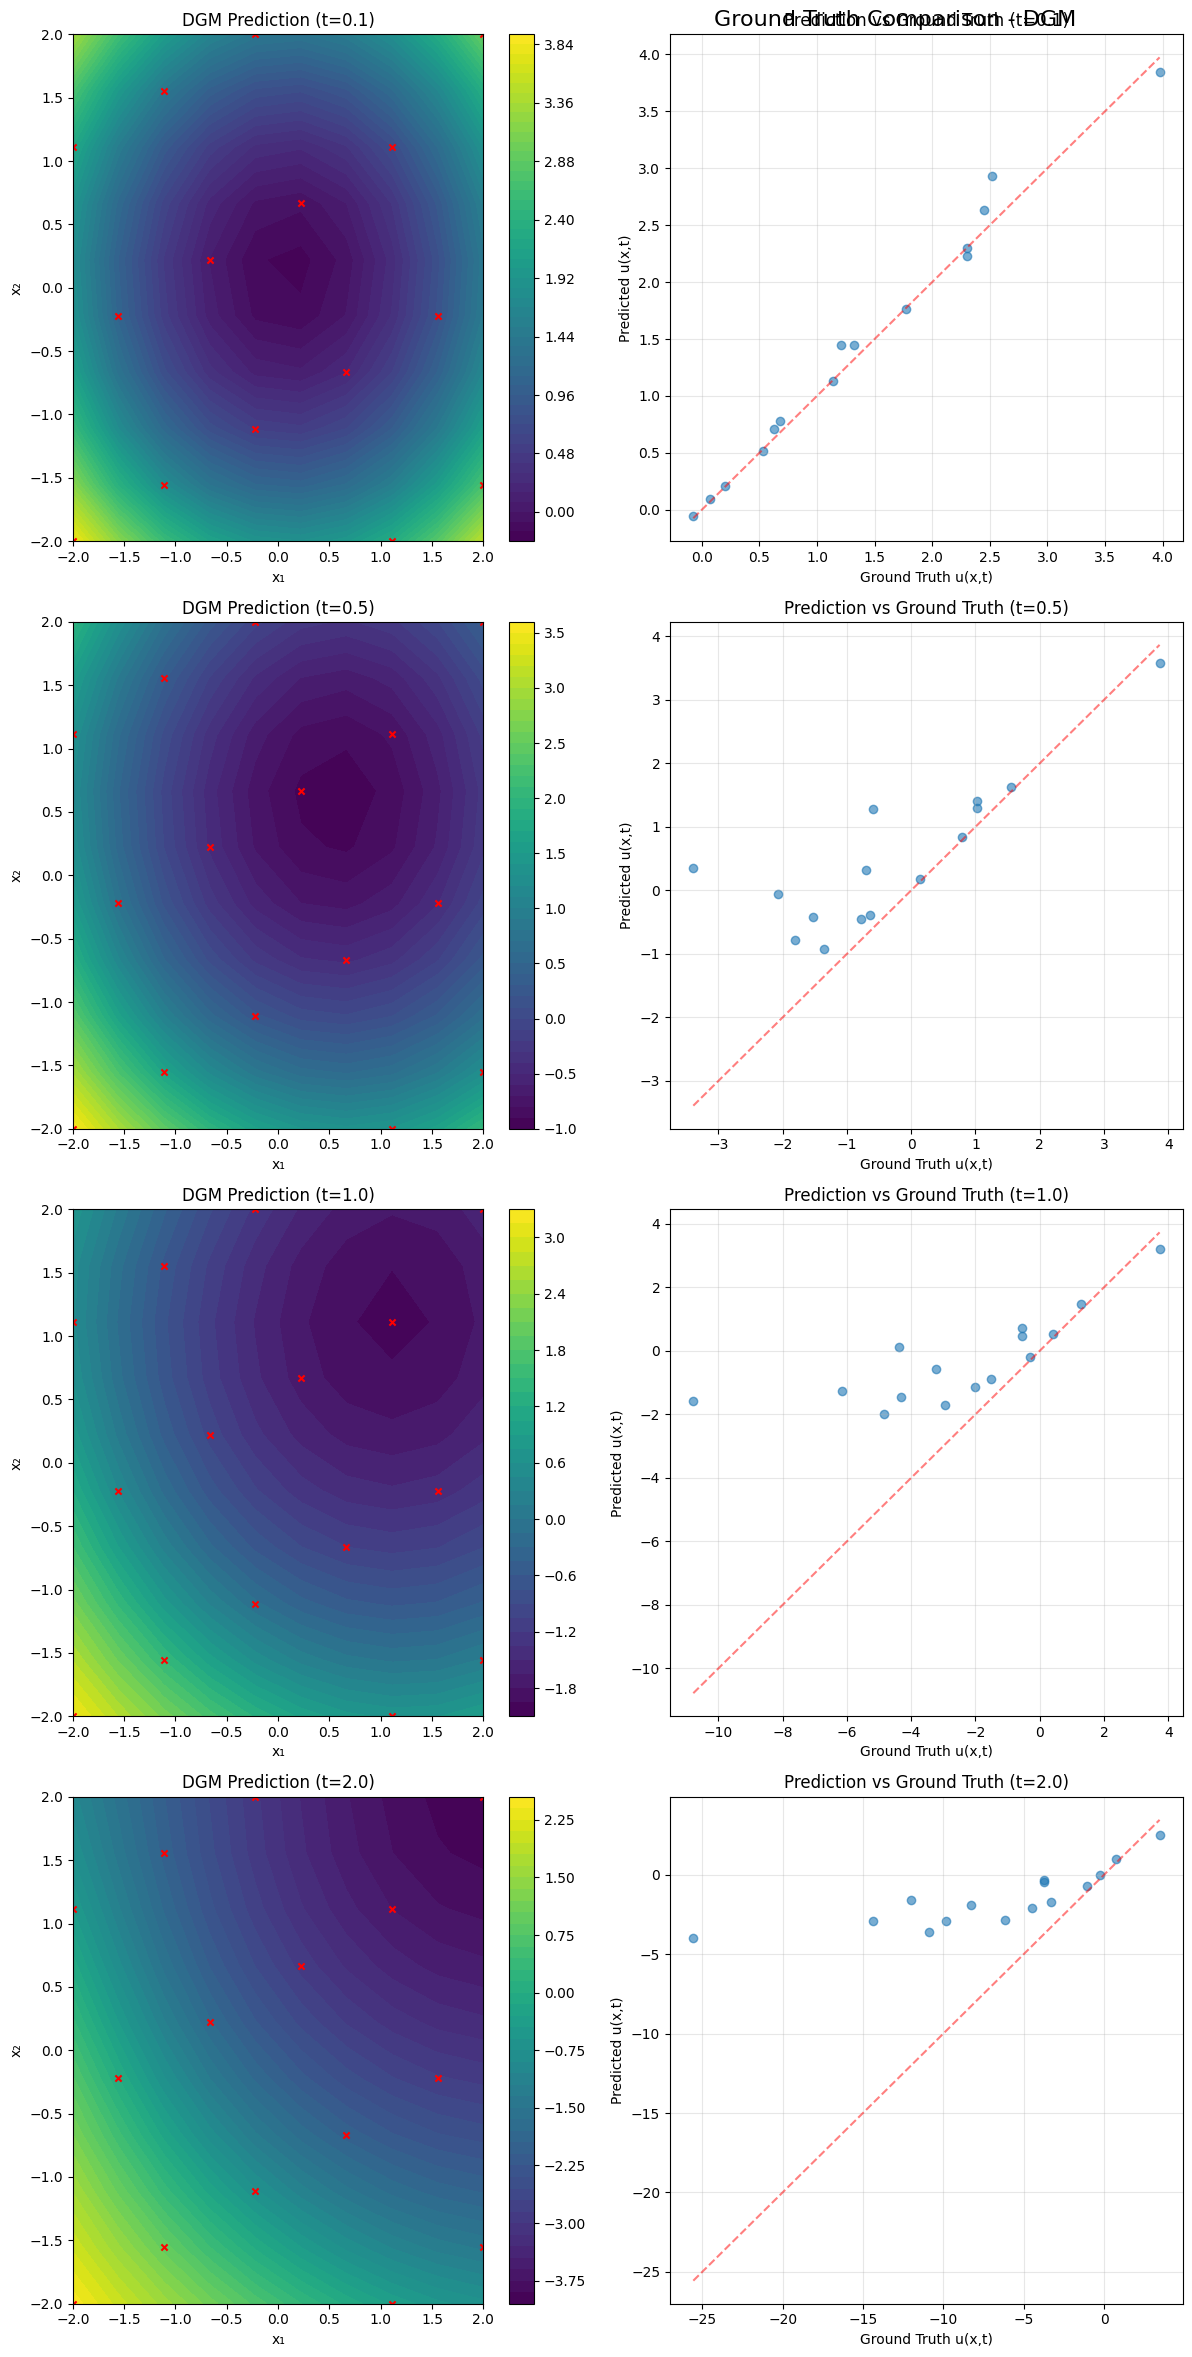

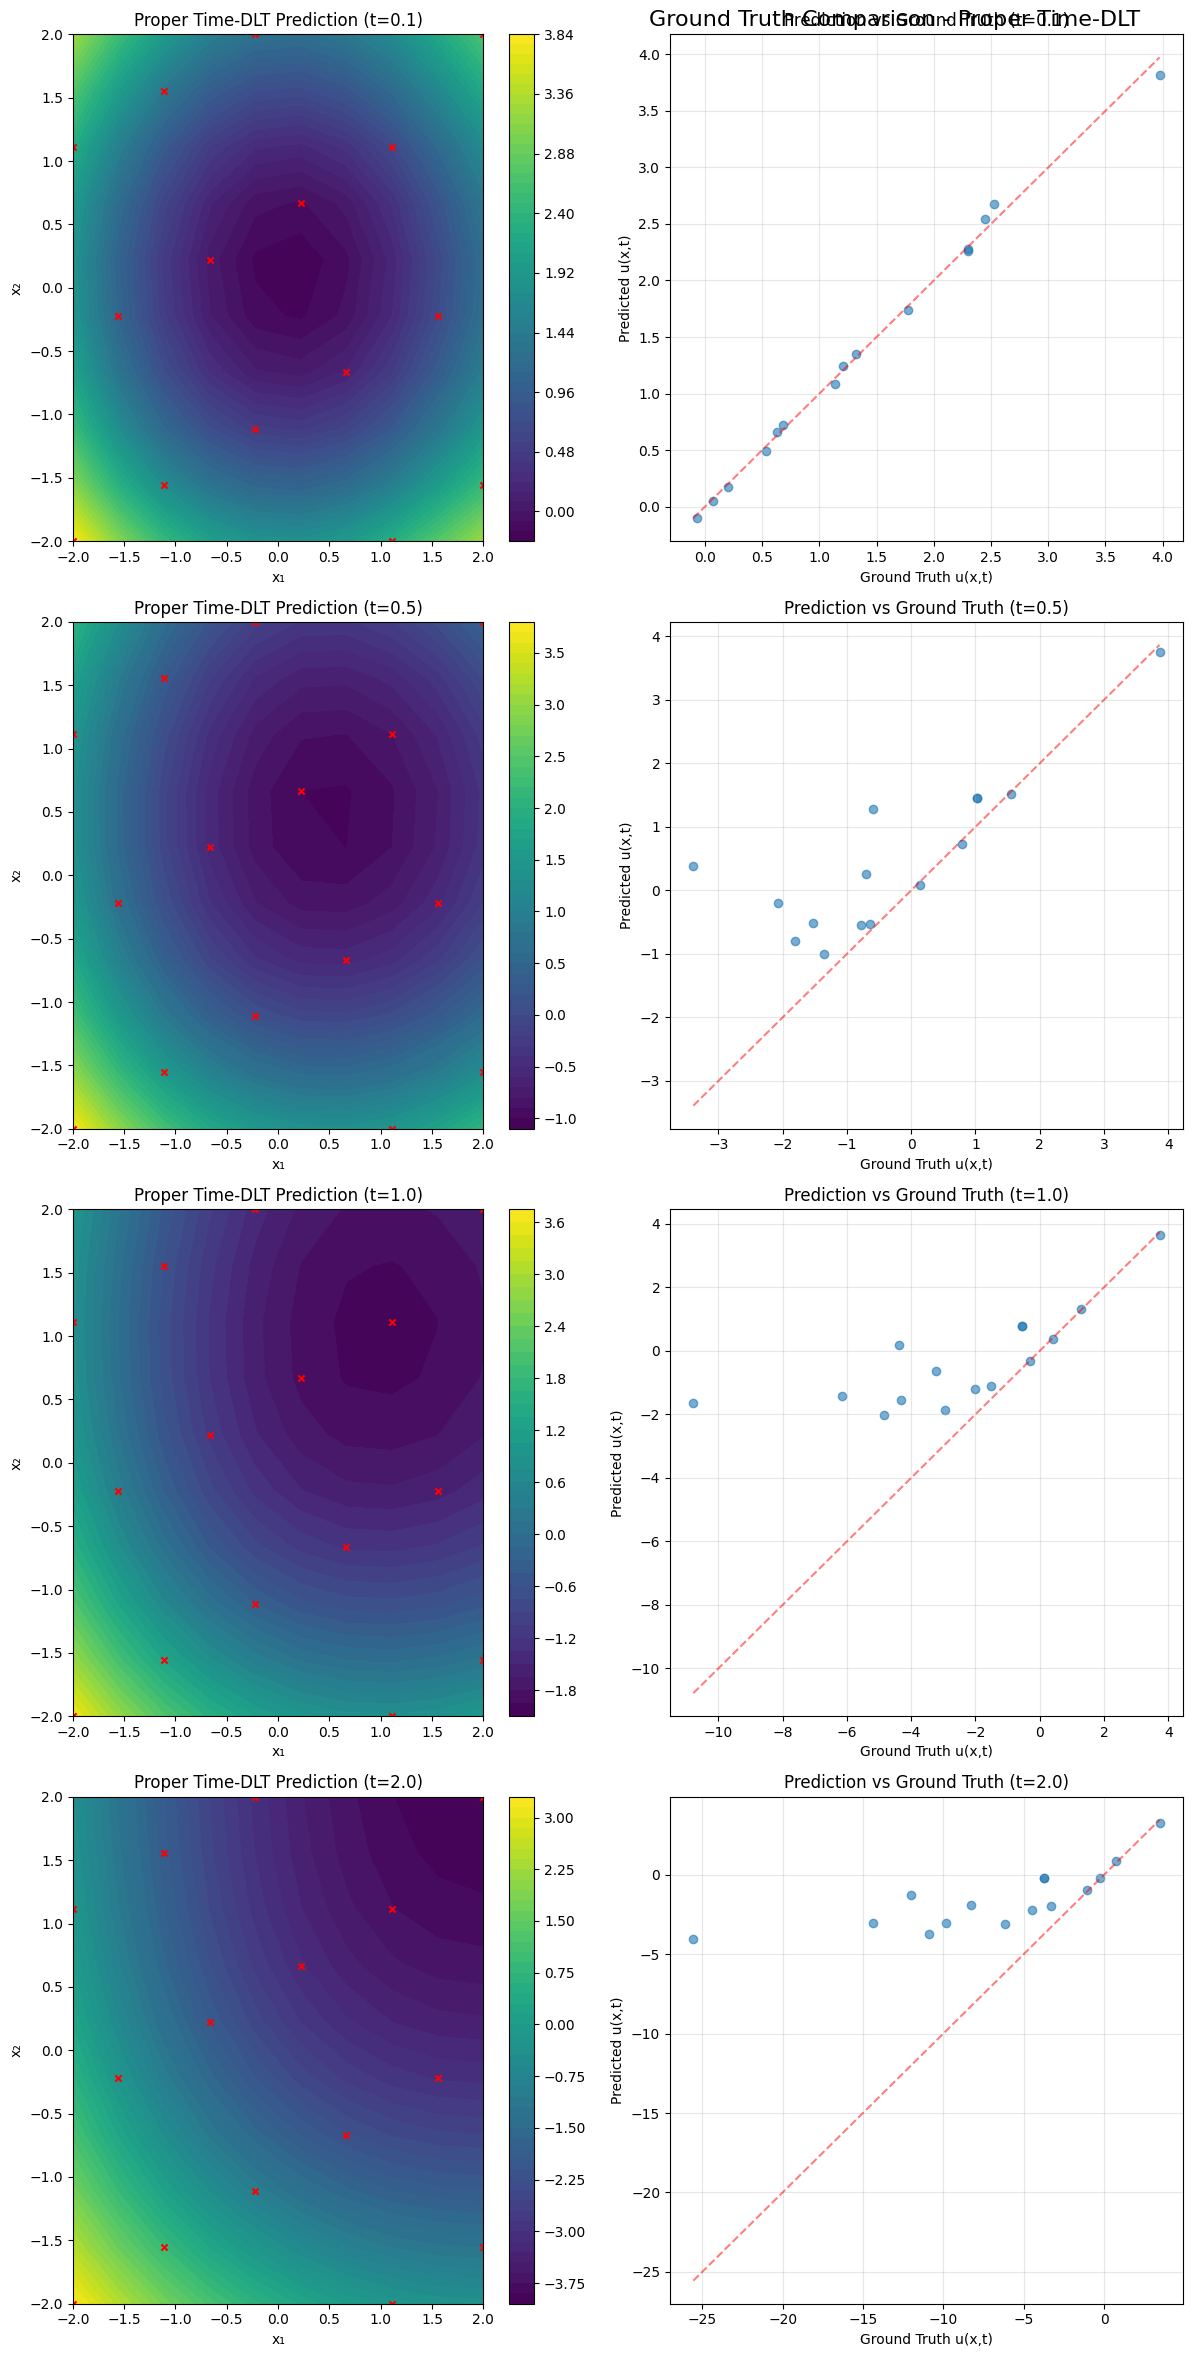


SUMMARY:
Training times: DGM = 142.40s, DLT = 95.35s

Errors vs Ground Truth:
Time       DGM Error       DLT Error       Ratio     
--------------------------------------------------
0.1        1.459033e-01    6.879584e-02    2.12      
0.5        1.304128e+00    1.286055e+00    1.01      
1.0        3.246500e+00    3.210225e+00    1.01      
2.0        7.699204e+00    7.685212e+00    1.00      

PDE Residuals:
Time       DGM Residual    DLT Residual   
----------------------------------------
0.1        2.251902e-01    2.238458e-01   
0.5        1.272565e-01    3.288447e-02   
1.0        8.208122e-02    7.187417e-02   
2.0        6.481756e-02    6.868154e-02   

------------------------------------------------------------
Cleaning up memory...

Final memory state:
GPU Memory: Allocated=0.02GB, Reserved=0.02GB


Test 2: 5D Exponential Hamiltonian

COMPLETE COMPARISON: DGM vs PROPER TIME-DLT
Problem: d=5, H=exponential, IC=quadratic

Initial memory state:
GPU Memory: Allocated=0.02GB, 

DGM Training: 100%|██████████| 30000/30000 [03:35<00:00, 139.05it/s, loss=2.566628]



Memory after DGM training:
GPU Memory: Allocated=0.02GB, Reserved=0.02GB

------------------------------------------------------------
Training Proper Time-DLT...

TRAINING PROPER TIME-DLT
Dimension: 5, Hamiltonian: exponential, IC: quadratic
Phase 1: Training gradient network h(x,t)...


Gradient Network Training: 100%|██████████| 12000/12000 [00:55<00:00, 216.28it/s, loss=0.051928]


Gradient network training complete. Final loss: 0.053835

Phase 2: Training main network u(x,t) using DLT...


Main Network Training (DLT): 100%|██████████| 18000/18000 [01:29<00:00, 200.59it/s, loss=0.009859]


Main network training complete. Final loss: 0.010088

Memory after DLT training:
GPU Memory: Allocated=0.02GB, Reserved=0.02GB


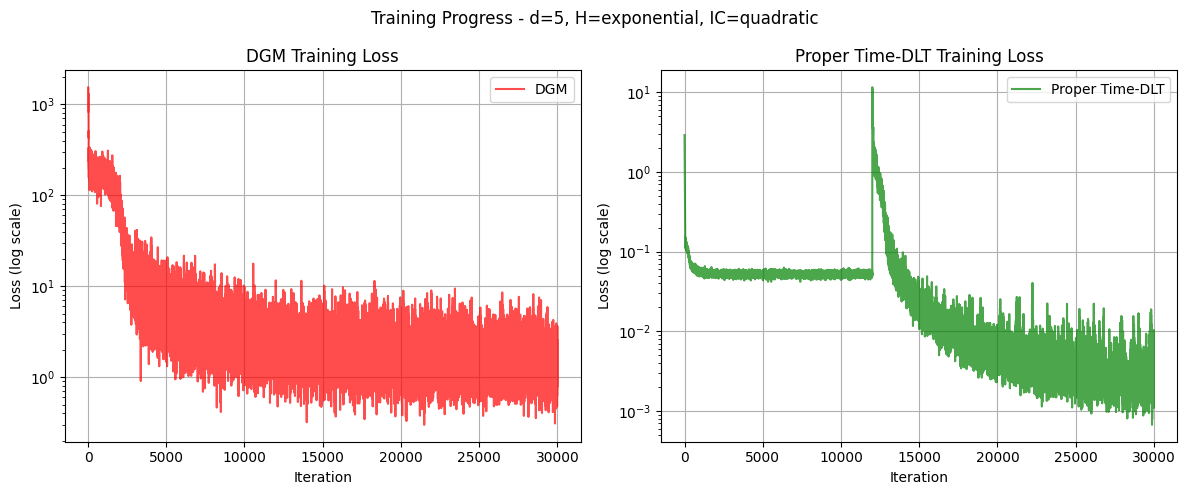


------------------------------------------------------------
Evaluating DGM with ground truth...

Evaluating at t = 0.1...
Computing ground truth for 10 points...
L2 error (on subset): 3.180105e-01

Evaluating at t = 0.5...
Computing ground truth for 10 points...
L2 error (on subset): 5.527462e-01

Evaluating at t = 1.0...
Computing ground truth for 10 points...
L2 error (on subset): 1.315503e+00

Evaluating at t = 2.0...
Computing ground truth for 10 points...
L2 error (on subset): 2.641563e+00

------------------------------------------------------------
Evaluating Proper Time-DLT with ground truth...

Evaluating at t = 0.1...
Computing ground truth for 10 points...
L2 error (on subset): 1.140577e+00

Evaluating at t = 0.5...
Computing ground truth for 10 points...
L2 error (on subset): 4.943742e-01

Evaluating at t = 1.0...
Computing ground truth for 10 points...
L2 error (on subset): 4.693822e-01

Evaluating at t = 2.0...
Computing ground truth for 10 points...
L2 error (on subset

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.cm as cm
from scipy.optimize import minimize
from tqdm import tqdm
import time
import gc
import os

# Set environment for PyTorch memory allocation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable cuDNN benchmark if available
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True


def clear_gpu_memory():
    """Clear GPU memory cache."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()


def print_memory_usage():
    """Print current GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")


# ============================================================================
# Neural Network Modules
# ============================================================================

class TimeParamMLP(nn.Module):
    """Time-parameterized MLP for HJ equation."""

    def __init__(self, input_dim, output_dim=1, hidden_dim=64, num_hidden=2, activation=nn.Tanh()):
        super().__init__()
        self.input_layer = nn.Linear(input_dim + 1, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = activation

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        t_expanded = t.expand(x.shape[0], 1)
        x_t = torch.cat([x, t_expanded], dim=1)

        x_t = self.activation(self.input_layer(x_t))
        for layer in self.hidden_layers:
            x_t = self.activation(layer(x_t))
        return self.output_layer(x_t)


class GradientNetwork(nn.Module):
    """Network that learns the mapping h: (x,t) → p = ∇u(x,t)"""

    def __init__(self, input_dim, hidden_dim=64, num_hidden=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim + 1, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden)
        ])
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.Tanh()

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        t_expanded = t.expand(x.shape[0], 1)
        x_t = torch.cat([x, t_expanded], dim=1)

        x_t = self.activation(self.input_layer(x_t))
        for layer in self.hidden_layers:
            x_t = self.activation(layer(x_t))
        return self.output_layer(x_t)


# ============================================================================
# Hamiltonian and Initial Condition Functions
# ============================================================================

def hamiltonian_quadratic(p):
    """Quadratic Hamiltonian: H(p) = |p|^2/2"""
    return 0.5 * torch.sum(p**2, dim=1, keepdim=True)


def hamiltonian_exponential(p):
    """Exponential Hamiltonian: H(p) = sum_i exp(p_i)"""
    p_clipped = torch.clamp(p, max=20)
    return torch.sum(torch.exp(p_clipped), dim=1, keepdim=True)


def initial_condition_quadratic(x):
    """Quadratic initial condition: g(x) = |x|^2/2"""
    return 0.5 * torch.sum(x**2, dim=1, keepdim=True)


def initial_condition_exponential(x):
    """Exponential initial condition: g(x) = sum_i exp(x_i)"""
    x_clipped = torch.clamp(x, -20, 20)
    return torch.sum(torch.exp(x_clipped), dim=1, keepdim=True)


def get_hamiltonian_fn(hamiltonian_type):
    """Get the Hamiltonian function."""
    if hamiltonian_type == 'quadratic':
        return hamiltonian_quadratic
    elif hamiltonian_type == 'exponential':
        return hamiltonian_exponential
    else:
        raise ValueError(f"Unsupported Hamiltonian type: {hamiltonian_type}")


def get_initial_condition_fn(ic_type):
    """Get the initial condition function."""
    if ic_type == 'quadratic':
        return initial_condition_quadratic
    elif ic_type == 'exponential':
        return initial_condition_exponential
    else:
        raise ValueError(f"Unsupported initial condition type: {ic_type}")


def analytical_solution_quadratic_quadratic(x, t):
    """Analytical solution for quadratic H and g: u(x,t) = |x|²/(2(1+t))"""
    x_norm_squared = torch.sum(x**2, dim=1, keepdim=True)
    return x_norm_squared / (2.0 * (1.0 + t))


def get_analytical_solution_fn(hamiltonian_type, ic_type):
    """Get analytical solution if available."""
    if hamiltonian_type == 'quadratic' and ic_type == 'quadratic':
        return analytical_solution_quadratic_quadratic
    else:
        return None


# ============================================================================
# Deep Galerkin Method (DGM)
# ============================================================================

class DeepGalerkinMethod:
    """Deep Galerkin Method for Hamilton-Jacobi equation."""

    def __init__(self, dim, network_type='mlp', hidden_dim=64, num_layers=2,
                 ic_weight=100.0, domain_bounds=(-2.0, 2.0),
                 hamiltonian_type='quadratic', ic_type='quadratic', device='cuda'):
        self.dim = dim
        self.device = device
        self.ic_weight = ic_weight
        self.domain_bounds = domain_bounds
        self.hamiltonian_type = hamiltonian_type
        self.ic_type = ic_type

        self.hamiltonian_fn = get_hamiltonian_fn(hamiltonian_type)
        self.initial_condition_fn = get_initial_condition_fn(ic_type)

        self.net = TimeParamMLP(dim, 1, hidden_dim, num_layers).to(device)
        self.optimizer = None

    def init_optimizer(self, lr=1e-3):
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def forward(self, x, t):
        return self.net(x, t)

    def calculate_pde_residual(self, x, t):
        x = x.detach().requires_grad_(True)
        u = self.forward(x, t)

        eps = 1e-4
        t_perturbed = t + eps
        u_perturbed = self.forward(x, t_perturbed)
        u_t = (u_perturbed - u) / eps

        grad_u = torch.autograd.grad(
            u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        hamiltonian_term = self.hamiltonian_fn(grad_u)
        residual = u_t + hamiltonian_term

        return residual

    def train_step(self, x_batch, t_batch):
        self.optimizer.zero_grad()

        mask_ic = (t_batch < 1e-6).squeeze(-1)
        mask_pde = ~mask_ic

        total_loss = 0.0

        if torch.any(mask_pde):
            x_pde = x_batch[mask_pde]
            t_pde = t_batch[mask_pde]

            pde_residual = self.calculate_pde_residual(x_pde, t_pde)
            pde_loss = torch.mean(pde_residual**2)
            total_loss += pde_loss

        if torch.any(mask_ic):
            x_ic = x_batch[mask_ic]
            t_ic = t_batch[mask_ic]

            u_ic = self.forward(x_ic, t_ic)
            g_ic = self.initial_condition_fn(x_ic)

            ic_loss = torch.mean((u_ic - g_ic)**2)
            total_loss += self.ic_weight * ic_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=10.0)
        self.optimizer.step()

        return total_loss.item()

    def train(self, epochs=5000, batch_size=100, t_values=[0.1, 0.5, 1.0],
              verbose=True, log_every=100):
        if verbose:
            print(f"\nTRAINING DEEP GALERKIN METHOD (DGM)")
            print(f"Dimension: {self.dim}, Hamiltonian: {self.hamiltonian_type}, IC: {self.ic_type}")
            print("="*60)

        loss_history = []

        if verbose:
            pbar = tqdm(range(epochs), desc="DGM Training")
        else:
            pbar = range(epochs)

        for epoch in pbar:
            x_low, x_high = self.domain_bounds
            x_batch = torch.rand(batch_size, self.dim, device=self.device)
            x_batch = x_batch * (x_high - x_low) + x_low

            if epoch < epochs // 10:
                ic_prob = 0.5
            else:
                ic_prob = 0.2

            ic_mask = torch.rand(batch_size, device=self.device) < ic_prob
            t_batch = torch.zeros(batch_size, 1, device=self.device)

            non_ic_indices = torch.where(~ic_mask)[0]
            if len(non_ic_indices) > 0:
                random_t_indices = torch.randint(0, len(t_values), (len(non_ic_indices),), device=self.device)
                t_batch[non_ic_indices] = torch.tensor([t_values[i] for i in random_t_indices], device=self.device).unsqueeze(1)

            loss = self.train_step(x_batch, t_batch)
            loss_history.append(loss)

            if verbose and isinstance(pbar, tqdm):
                if epoch % 10 == 0:
                    pbar.set_postfix({"loss": f"{loss:.6f}"})

        return loss_history

    def evaluate(self, x_test, t_test, analytical_solution=None):
        self.net.eval()

        with torch.no_grad():
            u_pred = self.forward(x_test, t_test)

            if analytical_solution is not None:
                u_exact = analytical_solution(x_test, t_test[0].item())
                error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
                return u_pred, u_exact, error

        return u_pred, None, None


# ============================================================================
# Proper Time-DLT with Gradient Network
# ============================================================================

class ProperTimeDLT:
    """Proper Time-DLT implementation using learned gradient network for sampling."""

    def __init__(self, dim, hidden_dim=64, num_layers=2, domain_bounds=(-2.0, 2.0),
                 hamiltonian_type='quadratic', ic_type='quadratic', device='cuda'):
        self.dim = dim
        self.device = device
        self.domain_bounds = domain_bounds
        self.hamiltonian_type = hamiltonian_type
        self.ic_type = ic_type

        self.hamiltonian_fn = get_hamiltonian_fn(hamiltonian_type)
        self.initial_condition_fn = get_initial_condition_fn(ic_type)

        self.net = TimeParamMLP(dim, 1, hidden_dim, num_layers).to(device)
        self.gradient_net = GradientNetwork(dim, hidden_dim, num_layers).to(device)

        self.optimizer = None
        self.grad_optimizer = None

    def init_optimizer(self, lr=1e-3, lr_grad=1e-3):
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.grad_optimizer = torch.optim.Adam(self.gradient_net.parameters(), lr=lr_grad)

    def forward(self, x, t):
        return self.net(x, t)

    def compute_grad_H(self, p):
        p = p.detach().requires_grad_(True)
        H = self.hamiltonian_fn(p)
        grad_H = torch.autograd.grad(H.sum(), p, create_graph=True)[0]
        return grad_H

    def compute_grad_g_star(self, p):
        if self.ic_type == 'quadratic':
            return p
        elif self.ic_type == 'exponential':
            eps = 1e-8
            p_safe = torch.clamp(p.abs(), min=eps)
            grad_g_star = torch.log(p_safe) * torch.sign(p)
            return grad_g_star
        else:
            raise ValueError(f"Unsupported IC type: {self.ic_type}")

    def compute_g_star(self, p):
        if self.ic_type == 'quadratic':
            return 0.5 * torch.sum(p**2, dim=1, keepdim=True)
        elif self.ic_type == 'exponential':
            eps = 1e-8
            p_abs = torch.abs(p) + eps
            log_term = p_abs * torch.log(p_abs) - p_abs
            sign_adjustment = torch.sign(p)
            adjusted_term = log_term * (1 + 0.1 * (1 - sign_adjustment))
            return torch.sum(adjusted_term, dim=1, keepdim=True)
        else:
            raise ValueError(f"Unsupported IC type: {self.ic_type}")

    def train_gradient_network(self, steps=2000, batch_size=100, t_values=[0.1, 0.5, 1.0]):
        print("Phase 1: Training gradient network h(x,t)...")

        loss_history = []
        pbar = tqdm(range(steps), desc="Gradient Network Training")

        for step in pbar:
            self.grad_optimizer.zero_grad()

            x_low, x_high = self.domain_bounds
            x_batch = torch.rand(batch_size, self.dim, device=self.device)
            x_batch = x_batch * (x_high - x_low) + x_low

            t_idx = torch.randint(0, len(t_values), (batch_size,), device=self.device)
            t_batch = torch.tensor([t_values[i] for i in t_idx], device=self.device).unsqueeze(1)

            p_pred = self.gradient_net(x_batch, t_batch)

            # Compute gradients (these functions handle gradient computation internally)
            grad_g_star = self.compute_grad_g_star(p_pred)
            grad_H = self.compute_grad_H(p_pred)
            x_reconstructed = grad_g_star + t_batch * grad_H

            reconstruction_loss = torch.mean((x_batch - x_reconstructed)**2)
            p_norm_penalty = 0.01 * torch.mean(torch.sum(p_pred**2, dim=1))

            t0_mask = (t_batch < 1e-6).squeeze()
            if torch.any(t0_mask):
                x_t0 = x_batch[t0_mask]
                p_t0 = p_pred[t0_mask]

                if self.ic_type == 'quadratic':
                    grad_g_true = x_t0
                elif self.ic_type == 'exponential':
                    grad_g_true = torch.exp(torch.clamp(x_t0, -20, 20))

                ic_loss = torch.mean((p_t0 - grad_g_true)**2)
                reconstruction_loss += 10.0 * ic_loss

            total_loss = reconstruction_loss + p_norm_penalty
            total_loss.backward()

            torch.nn.utils.clip_grad_norm_(self.gradient_net.parameters(), max_norm=5.0)

            self.grad_optimizer.step()
            loss_history.append(total_loss.item())

            if step % 10 == 0:
                pbar.set_postfix({"loss": f"{total_loss.item():.6f}"})

        # Clean up gradient computation graph
        del reconstruction_loss, p_norm_penalty, total_loss
        clear_gpu_memory()

        print(f"Gradient network training complete. Final loss: {loss_history[-1]:.6f}")
        return loss_history

    def sample_p_via_gradient_network(self, batch_size, t_values):
        x_low, x_high = self.domain_bounds
        x_sample = torch.rand(batch_size, self.dim, device=self.device)
        x_sample = x_sample * (x_high - x_low) + x_low

        t_idx = torch.randint(0, len(t_values), (batch_size,), device=self.device)
        t_batch = torch.tensor([t_values[i] for i in t_idx], device=self.device).unsqueeze(1)

        with torch.no_grad():
            p_batch = self.gradient_net(x_sample, t_batch)

        # Compute gradients (grad_H will handle gradient computation internally)
        grad_g_star = self.compute_grad_g_star(p_batch)
        grad_H = self.compute_grad_H(p_batch)
        x_batch = grad_g_star + t_batch * grad_H

        return p_batch, x_batch, t_batch

    def dlt_loss(self, p_batch, x_batch, t_batch):
        u_pred = self.net(x_batch, t_batch)

        inner_product = torch.sum(x_batch * p_batch, dim=1, keepdim=True)
        g_star = self.compute_g_star(p_batch)
        H_p = self.hamiltonian_fn(p_batch)

        target = inner_product - g_star - t_batch * H_p

        loss = torch.mean((u_pred - target)**2)

        return loss

    def train_main_network(self, steps=3000, batch_size=100, t_values=[0.1, 0.5, 1.0]):
        print("\nPhase 2: Training main network u(x,t) using DLT...")

        loss_history = []
        pbar = tqdm(range(steps), desc="Main Network Training (DLT)")

        for step in pbar:
            self.optimizer.zero_grad()

            p_batch, x_batch, t_batch = self.sample_p_via_gradient_network(batch_size, t_values)

            loss = self.dlt_loss(p_batch, x_batch, t_batch)

            ic_mask = (t_batch < 1e-6).squeeze()
            if torch.any(ic_mask):
                x_ic = x_batch[ic_mask]
                t_ic = t_batch[ic_mask]

                u_ic_pred = self.net(x_ic, t_ic)
                g_ic = self.initial_condition_fn(x_ic)

                ic_loss = torch.mean((u_ic_pred - g_ic)**2)
                loss += 100.0 * ic_loss

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=5.0)

            self.optimizer.step()
            loss_history.append(loss.item())

            if step % 10 == 0:
                pbar.set_postfix({"loss": f"{loss.item():.6f}"})

        # Clean up
        del loss
        clear_gpu_memory()

        print(f"Main network training complete. Final loss: {loss_history[-1]:.6f}")
        return loss_history

    def train(self, epochs=5000, batch_size=100, t_values=[0.1, 0.5, 1.0],
              verbose=True, log_every=100):
        if verbose:
            print(f"\nTRAINING PROPER TIME-DLT")
            print(f"Dimension: {self.dim}, Hamiltonian: {self.hamiltonian_type}, IC: {self.ic_type}")
            print("="*60)

        grad_steps = int(0.4 * epochs)
        grad_loss_history = self.train_gradient_network(grad_steps, batch_size, t_values)

        main_steps = int(0.6 * epochs)
        main_loss_history = self.train_main_network(main_steps, batch_size, t_values)

        total_loss_history = grad_loss_history + main_loss_history

        return total_loss_history

    def evaluate(self, x_test, t_test, analytical_solution=None):
        self.net.eval()
        self.gradient_net.eval()

        with torch.no_grad():
            u_pred = self.forward(x_test, t_test)

            if analytical_solution is not None:
                u_exact = analytical_solution(x_test, t_test[0].item())
                error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
                return u_pred, u_exact, error

        return u_pred, None, None


# ============================================================================
# Ground Truth Computation using Legendre Transform
# ============================================================================

def compute_legendre_transform_scipy(x_point, t_value, hamiltonian_fn, g_star_fn,
                                   initial_p=None, bounds=None, device='cpu'):
    """Compute u(x,t) = sup_p [<x,p> - g*(p) - t*H(p)] using scipy optimization."""
    dim = len(x_point)

    def objective(p):
        p_torch = torch.tensor(p, dtype=torch.float32, device=device).unsqueeze(0)
        x_torch = torch.tensor(x_point, dtype=torch.float32, device=device).unsqueeze(0)

        inner_prod = torch.sum(x_torch * p_torch)
        g_star_val = g_star_fn(p_torch).item()
        h_val = hamiltonian_fn(p_torch).item()

        return -(inner_prod.item() - g_star_val - t_value * h_val)

    if initial_p is None:
        initial_p = x_point.copy()

    if bounds is None:
        bounds = [(-10, 10) for _ in range(dim)]

    result = minimize(objective, initial_p, method='L-BFGS-B', bounds=bounds,
                     options={'ftol': 1e-12, 'gtol': 1e-10})

    optimal_p = result.x
    u_value = -result.fun

    return u_value, optimal_p


def compute_legendre_transform_torch(x_batch, t_batch, hamiltonian_fn, g_star_fn,
                                   n_iterations=1000, lr=0.1, device='cuda'):
    """Compute u(x,t) = sup_p [<x,p> - g*(p) - t*H(p)] using PyTorch optimization."""
    batch_size, dim = x_batch.shape

    p = x_batch.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([p], lr=lr)

    for _ in range(n_iterations):
        optimizer.zero_grad()

        inner_prod = torch.sum(x_batch * p, dim=1, keepdim=True)
        g_star_val = g_star_fn(p)
        h_val = hamiltonian_fn(p)

        objective = inner_prod - g_star_val - t_batch * h_val
        loss = -torch.mean(objective)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            p.clamp_(-20, 20)

    with torch.no_grad():
        inner_prod = torch.sum(x_batch * p, dim=1, keepdim=True)
        g_star_val = g_star_fn(p)
        h_val = hamiltonian_fn(p)
        u_values = inner_prod - g_star_val - t_batch * h_val

    return u_values, p.detach()


def evaluate_with_ground_truth(solver, x_test, t_values, use_scipy=False,
                             n_ground_truth_points=20, verbose=True):
    """Evaluate the solver and compare with ground truth from Legendre transform."""
    device = solver.device
    results = {}

    hamiltonian_fn = solver.hamiltonian_fn

    if hasattr(solver, 'compute_g_star'):
        g_star_fn = solver.compute_g_star
    else:
        if solver.ic_type == 'quadratic':
            g_star_fn = lambda p: 0.5 * torch.sum(p**2, dim=1, keepdim=True)
        elif solver.ic_type == 'exponential':
            def g_star_fn(p):
                eps = 1e-8
                p_abs = torch.abs(p) + eps
                log_term = p_abs * torch.log(p_abs) - p_abs
                sign_adjustment = torch.sign(p)
                adjusted_term = log_term * (1 + 0.1 * (1 - sign_adjustment))
                return torch.sum(adjusted_term, dim=1, keepdim=True)
        else:
            raise ValueError(f"Unsupported IC type: {solver.ic_type}")

    n_ground_truth_points = min(n_ground_truth_points, x_test.shape[0])
    indices = torch.linspace(0, x_test.shape[0]-1, n_ground_truth_points, dtype=torch.long)
    x_subset = x_test[indices]

    for t in t_values:
        if verbose:
            print(f"\nEvaluating at t = {t}...")

        t_test = torch.ones(x_test.shape[0], 1, device=device) * t
        t_subset = torch.ones(n_ground_truth_points, 1, device=device) * t

        with torch.no_grad():
            u_pred_all = solver.forward(x_test, t_test)

        u_pred_subset = u_pred_all[indices]

        if verbose:
            print(f"Computing ground truth for {n_ground_truth_points} points...")

        if use_scipy:
            u_ground_truth = []
            optimal_p_list = []

            for i in tqdm(range(n_ground_truth_points), desc="Ground truth (scipy)"):
                x_point = x_subset[i].cpu().numpy()
                u_val, p_opt = compute_legendre_transform_scipy(
                    x_point, t, hamiltonian_fn, g_star_fn, device=device
                )
                u_ground_truth.append(u_val)
                optimal_p_list.append(p_opt)

            u_ground_truth = torch.tensor(u_ground_truth, device=device).unsqueeze(1)
            optimal_p = torch.tensor(np.array(optimal_p_list), device=device)
        else:
            u_ground_truth, optimal_p = compute_legendre_transform_torch(
                x_subset, t_subset, hamiltonian_fn, g_star_fn,
                n_iterations=2000, lr=0.1, device=device
            )

        error = torch.sqrt(torch.mean((u_pred_subset - u_ground_truth)**2))

        results[t] = {
            'u_pred_all': u_pred_all.cpu().numpy(),
            'u_pred_subset': u_pred_subset.cpu().numpy(),
            'u_ground_truth': u_ground_truth.cpu().numpy(),
            'x_subset': x_subset.cpu().numpy(),
            'optimal_p': optimal_p.cpu().numpy(),
            'error': error.item(),
            'indices': indices.cpu().numpy()
        }

        if verbose:
            print(f"L2 error (on subset): {error.item():.6e}")

    # Clean up
    del u_pred_all, u_pred_subset, u_ground_truth
    clear_gpu_memory()

    return results


# ============================================================================
# Visualization Functions
# ============================================================================

def visualize_sampling_process(solver, t_value=0.5, n_samples=100, figsize=(18, 12)):
    """Visualize the sampling process in 2D."""
    if solver.dim != 2:
        print("This visualization is designed for 2D problems only.")
        return

    solver.gradient_net.eval()

    x_low, x_high = solver.domain_bounds
    x_sample = torch.rand(n_samples, solver.dim, device=solver.device)
    x_sample = x_sample * (x_high - x_low) + x_low

    t_batch = torch.ones(n_samples, 1, device=solver.device) * t_value

    with torch.no_grad():
        p_batch = solver.gradient_net(x_sample, t_batch)

    # Compute gradients (grad_H will handle gradient computation internally)
    grad_g_star = solver.compute_grad_g_star(p_batch)
    grad_H = solver.compute_grad_H(p_batch)
    x_mapped = grad_g_star + t_batch * grad_H

    x_np = x_sample.cpu().numpy()
    p_np = p_batch.detach().cpu().numpy()
    x_mapped_np = x_mapped.detach().cpu().numpy()

    fig = plt.figure(figsize=figsize)

    # 1. Original x samples
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(x_np[:, 0], x_np[:, 1], c='blue', alpha=0.6, s=30)
    ax1.set_title(f'Original x samples (uniform)\nt = {t_value}', fontsize=14)
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(x_low, x_high)
    ax1.set_ylim(x_low, x_high)

    # 2. p = h(x,t) values
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(p_np[:, 0], p_np[:, 1], c='red', alpha=0.6, s=30)
    ax2.set_title(f'p = h(x,t) values\n(from gradient network)', fontsize=14)
    ax2.set_xlabel('p₁')
    ax2.set_ylabel('p₂')
    ax2.grid(True, alpha=0.3)

    # 3. x' = ∇g*(p) + t·∇H(p)
    ax3 = plt.subplot(2, 3, 3)
    ax3.scatter(x_mapped_np[:, 0], x_mapped_np[:, 1], c='green', alpha=0.6, s=30)
    ax3.set_title(f"x' = ∇g*(p) + t·∇H(p)\n(where p lands)", fontsize=14)
    ax3.set_xlabel('x₁')
    ax3.set_ylabel('x₂')
    ax3.grid(True, alpha=0.3)

    # 4. Flow visualization
    ax4 = plt.subplot(2, 3, 4)
    ax4.scatter(x_np[:, 0], x_np[:, 1], c='blue', alpha=0.3, s=20, label='Original x')
    ax4.scatter(x_mapped_np[:, 0], x_mapped_np[:, 1], c='green', alpha=0.3, s=20, label="Mapped x'")

    for i in range(0, n_samples, max(1, n_samples//20)):
        arrow = FancyArrowPatch((x_np[i, 0], x_np[i, 1]),
                               (x_mapped_np[i, 0], x_mapped_np[i, 1]),
                               arrowstyle='->', mutation_scale=15,
                               color='gray', alpha=0.5)
        ax4.add_patch(arrow)

    ax4.set_title(f'Mapping: x → x\'\n(via p = h(x,t))', fontsize=14)
    ax4.set_xlabel('x₁')
    ax4.set_ylabel('x₂')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    # 5. Heat map of reconstruction error
    ax5 = plt.subplot(2, 3, 5)
    reconstruction_error = np.linalg.norm(x_np - x_mapped_np, axis=1)
    scatter5 = ax5.scatter(x_np[:, 0], x_np[:, 1], c=reconstruction_error,
                          cmap='hot', s=50, alpha=0.8)
    cbar = plt.colorbar(scatter5, ax=ax5)
    cbar.set_label('|x - x\'|')
    ax5.set_title('Reconstruction Error\n|x - x\'|', fontsize=14)
    ax5.set_xlabel('x₁')
    ax5.set_ylabel('x₂')
    ax5.grid(True, alpha=0.3)

    # 6. Vector field
    ax6 = plt.subplot(2, 3, 6)
    grid_size = 15
    x1_grid = np.linspace(x_low, x_high, grid_size)
    x2_grid = np.linspace(x_low, x_high, grid_size)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    x_grid_flat = torch.tensor(np.column_stack([X1.ravel(), X2.ravel()]),
                               dtype=torch.float32, device=solver.device)
    t_grid = torch.ones(x_grid_flat.shape[0], 1, device=solver.device) * t_value

    with torch.no_grad():
        p_grid = solver.gradient_net(x_grid_flat, t_grid)

    # Compute gradients outside no_grad context
    grad_g_star_grid = solver.compute_grad_g_star(p_grid)
    grad_H_grid = solver.compute_grad_H(p_grid)
    x_mapped_grid = grad_g_star_grid + t_grid * grad_H_grid

    displacement = x_mapped_grid.detach().cpu().numpy() - x_grid_flat.cpu().numpy()
    U = displacement[:, 0].reshape(grid_size, grid_size)
    V = displacement[:, 1].reshape(grid_size, grid_size)

    ax6.quiver(X1, X2, U, V, alpha=0.6)
    ax6.set_title(f'Displacement Field\nx → x\'', fontsize=14)
    ax6.set_xlabel('x₁')
    ax6.set_ylabel('x₂')
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim(x_low, x_high)
    ax6.set_ylim(x_low, x_high)

    plt.suptitle(f'Sampling Process Visualization\n{solver.hamiltonian_type.capitalize()} Hamiltonian, {solver.ic_type.capitalize()} IC',
                 fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"\nSampling Statistics at t = {t_value}:")
    print(f"Average reconstruction error |x - x'|: {np.mean(reconstruction_error):.6f}")
    print(f"Max reconstruction error: {np.max(reconstruction_error):.6f}")
    print(f"Min reconstruction error: {np.min(reconstruction_error):.6f}")

    # Clean up
    del x_sample, p_batch, x_mapped, x_grid_flat, p_grid
    clear_gpu_memory()

    return {
        'x_sample': x_np,
        'p_batch': p_np,
        'x_mapped': x_mapped_np,
        'reconstruction_error': reconstruction_error
    }


def visualize_ground_truth_comparison(results, t_values, solver_name="Solver", dim=2):
    """Visualize comparison between neural network predictions and ground truth."""
    n_times = len(t_values)

    if dim == 1:
        fig, axes = plt.subplots(1, n_times, figsize=(6*n_times, 5))
        if n_times == 1:
            axes = [axes]

        for i, t in enumerate(t_values):
            ax = axes[i]
            data = results[t]

            x_full = np.linspace(-2, 2, len(data['u_pred_all']))

            ax.plot(x_full, data['u_pred_all'], 'b-', label=f'{solver_name} prediction',
                   linewidth=2, alpha=0.7)
            ax.scatter(data['x_subset'], data['u_ground_truth'],
                      color='red', s=50, label='Ground truth (Legendre)', zorder=5)
            ax.scatter(data['x_subset'], data['u_pred_subset'],
                      color='green', s=30, marker='^', label='NN at GT points', zorder=4)

            ax.set_xlabel('x')
            ax.set_ylabel('u(x,t)')
            ax.set_title(f't = {t}, L2 error = {data["error"]:.4e}')
            ax.legend()
            ax.grid(True, alpha=0.3)

    elif dim == 2:
        fig = plt.figure(figsize=(18, 6*n_times))

        for i, t in enumerate(t_values):
            data = results[t]

            n_points = int(np.sqrt(len(data['u_pred_all'])))
            u_pred_grid = data['u_pred_all'].reshape(n_points, n_points)

            x1 = np.linspace(-2, 2, n_points)
            x2 = np.linspace(-2, 2, n_points)
            X1, X2 = np.meshgrid(x1, x2)

            ax1 = plt.subplot(n_times, 3, 3*i + 1)
            im1 = ax1.contourf(X1, X2, u_pred_grid, levels=50, cmap='viridis')
            ax1.scatter(data['x_subset'][:, 0], data['x_subset'][:, 1],
                       color='red', s=20, marker='x', label='GT points')
            plt.colorbar(im1, ax=ax1)
            ax1.set_title(f'{solver_name} Prediction (t={t})')
            ax1.set_xlabel('x₁')
            ax1.set_ylabel('x₂')

            ax2 = plt.subplot(n_times, 3, 3*i + 2)
            ax2.scatter(data['u_ground_truth'], data['u_pred_subset'], alpha=0.6)

            min_val = min(data['u_ground_truth'].min(), data['u_pred_subset'].min())
            max_val = max(data['u_ground_truth'].max(), data['u_pred_subset'].max())
            ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

            ax2.set_xlabel('Ground Truth u(x,t)')
            ax2.set_ylabel('Predicted u(x,t)')
            ax2.set_title(f'Prediction vs Ground Truth (t={t})')
            ax2.grid(True, alpha=0.3)

            # ax3 = plt.subplot(n_times, 3, 3*i + 3)
            # errors = np.abs(data['u_pred_subset'] - data['u_ground_truth'].flatten())
            # ax3.hist(errors, bins=20, alpha=0.7, color='blue', edgecolor='black')
            # ax3.set_xlabel('|Prediction - Ground Truth|')
            # ax3.set_ylabel('Count')
            # ax3.set_title(f'Error Distribution (t={t})\nMean: {np.mean(errors):.4e}')
            # ax3.grid(True, alpha=0.3)

    plt.suptitle(f'Ground Truth Comparison - {solver_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


def calculate_pde_residual(solver, x_test, t_test):
    """Calculate PDE residual for evaluation."""
    x_test_grad = x_test.detach().clone().requires_grad_(True)

    u = solver.forward(x_test_grad, t_test)

    eps = 1e-4
    t_perturbed = t_test + eps
    u_perturbed = solver.forward(x_test_grad, t_perturbed)
    u_t = (u_perturbed - u) / eps

    grad_u = torch.autograd.grad(
        u, x_test_grad, grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True)[0]

    hamiltonian_term = solver.hamiltonian_fn(grad_u)
    residual = u_t + hamiltonian_term

    pde_norm = torch.sqrt(torch.mean(residual**2))

    # Clean up
    del u, u_perturbed, u_t, grad_u, hamiltonian_term, residual, x_test_grad

    return pde_norm.detach()


# ============================================================================
# Main Comparison Function
# ============================================================================

def compare_methods_complete(dim=2, hamiltonian_type='exponential', ic_type='quadratic',
                           t_values=[0.1, 0.5, 1.0], steps=3000,
                           n_ground_truth_points=25, visualize_sampling=True):
    """Complete comparison of DGM and Proper Time-DLT with ground truth."""

    print(f"\n{'='*80}")
    print(f"COMPLETE COMPARISON: DGM vs PROPER TIME-DLT")
    print(f"Problem: d={dim}, H={hamiltonian_type}, IC={ic_type}")
    print(f"{'='*80}")

    # Print initial memory usage
    print("\nInitial memory state:")
    print_memory_usage()

    # Initialize solvers with smaller networks for memory efficiency
    dgm_solver = DeepGalerkinMethod(
        dim=dim,
        hidden_dim=64,  # Reduced from 128
        num_layers=2,   # Reduced from 3
        hamiltonian_type=hamiltonian_type,
        ic_type=ic_type,
        device=device
    )

    dlt_solver = ProperTimeDLT(
        dim=dim,
        hidden_dim=64,  # Reduced from 128
        num_layers=2,   # Reduced from 3
        hamiltonian_type=hamiltonian_type,
        ic_type=ic_type,
        device=device
    )

    dgm_solver.init_optimizer(lr=1e-3)
    dlt_solver.init_optimizer(lr=1e-3, lr_grad=1e-3)

    # Train DGM
    print("\n" + "-"*60)
    print("Training DGM...")
    start_time = time.time()
    dgm_loss_history = dgm_solver.train(
        epochs=steps,
        batch_size=100,  # Reduced from 200
        t_values=t_values,
        verbose=True
    )
    dgm_train_time = time.time() - start_time

    # Memory check
    print("\nMemory after DGM training:")
    print_memory_usage()
    clear_gpu_memory()

    # Train Proper Time-DLT
    print("\n" + "-"*60)
    print("Training Proper Time-DLT...")
    start_time = time.time()
    dlt_loss_history = dlt_solver.train(
        epochs=steps,
        batch_size=100,  # Reduced from 200
        t_values=t_values,
        verbose=True
    )
    dlt_train_time = time.time() - start_time

    # Memory check
    print("\nMemory after DLT training:")
    print_memory_usage()
    clear_gpu_memory()

    # Plot training losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.semilogy(dgm_loss_history, 'r-', label='DGM', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('DGM Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.semilogy(dlt_loss_history, 'g-', label='Proper Time-DLT', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('Proper Time-DLT Training Loss')
    plt.grid(True)
    plt.legend()

    plt.suptitle(f'Training Progress - d={dim}, H={hamiltonian_type}, IC={ic_type}')
    plt.tight_layout()
    plt.show()

    # Visualize sampling process for DLT (if 2D and requested)
    if dim == 2 and visualize_sampling:
        print("\n" + "-"*60)
        print("Visualizing DLT sampling process...")
        sampling_data = visualize_sampling_process(dlt_solver, t_value=t_values[1], n_samples=50)
        clear_gpu_memory()

    # Generate test points
    if dim == 1:
        x_test = torch.linspace(-2, 2, 100).unsqueeze(1).to(device)
    else:
        points_per_dim = min(20, int(100**(1/dim)))
        grid_1d = torch.linspace(-2, 2, points_per_dim)
        grids = torch.meshgrid(*[grid_1d for _ in range(dim)], indexing='ij')
        x_test = torch.stack([g.flatten() for g in grids], dim=1).to(device)

    # Get analytical solution if available
    analytical_solution = get_analytical_solution_fn(hamiltonian_type, ic_type)

    # Evaluate with ground truth
    print("\n" + "-"*60)
    print("Evaluating DGM with ground truth...")
    dgm_results = evaluate_with_ground_truth(
        dgm_solver, x_test, t_values,
        use_scipy=(dim <= 2),
        n_ground_truth_points=n_ground_truth_points
    )

    print("\n" + "-"*60)
    print("Evaluating Proper Time-DLT with ground truth...")
    dlt_results = evaluate_with_ground_truth(
        dlt_solver, x_test, t_values,
        use_scipy=(dim <= 2),
        n_ground_truth_points=n_ground_truth_points
    )

    # Calculate PDE residuals
    print("\n" + "-"*60)
    print("Computing PDE residuals...")
    pde_residuals = {'dgm': {}, 'dlt': {}}

    for t in t_values:
        t_test = torch.ones(x_test.shape[0], 1, device=device) * t
        pde_residuals['dgm'][t] = calculate_pde_residual(dgm_solver, x_test, t_test).item()
        pde_residuals['dlt'][t] = calculate_pde_residual(dlt_solver, x_test, t_test).item()
        clear_gpu_memory()

    # Visualize results
    if dim <= 2:
        print("\nVisualizing results...")
        visualize_ground_truth_comparison(dgm_results, t_values, "DGM", dim)
        visualize_ground_truth_comparison(dlt_results, t_values, "Proper Time-DLT", dim)

    # Print summary
    print("\n" + "="*80)
    print("SUMMARY:")
    print(f"Training times: DGM = {dgm_train_time:.2f}s, DLT = {dlt_train_time:.2f}s")
    print("\nErrors vs Ground Truth:")
    print(f"{'Time':<10} {'DGM Error':<15} {'DLT Error':<15} {'Ratio':<10}")
    print("-" * 50)

    for t in t_values:
        dgm_error = dgm_results[t]['error']
        dlt_error = dlt_results[t]['error']
        ratio = dgm_error / dlt_error if dlt_error > 0 else float('inf')
        print(f"{t:<10.1f} {dgm_error:<15.6e} {dlt_error:<15.6e} {ratio:<10.2f}")

    print("\nPDE Residuals:")
    print(f"{'Time':<10} {'DGM Residual':<15} {'DLT Residual':<15}")
    print("-" * 40)

    for t in t_values:
        print(f"{t:<10.1f} {pde_residuals['dgm'][t]:<15.6e} {pde_residuals['dlt'][t]:<15.6e}")

    # Clean up
    print("\n" + "-"*60)
    print("Cleaning up memory...")
    del dgm_solver, dlt_solver, x_test
    clear_gpu_memory()

    print("\nFinal memory state:")
    print_memory_usage()

    return dgm_results, dlt_results, pde_residuals


# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)

    print("HAMILTON-JACOBI EQUATION SOLVER")
    print("Comparing Deep Galerkin Method vs Proper Time-DLT")
    print("="*80)

    # Test 1: 2D Exponential Hamiltonian with visualization
    print("\nTest 1: 2D Exponential Hamiltonian")
    results_2d = compare_methods_complete(
        dim=2,
        hamiltonian_type='exponential',
        ic_type='quadratic',
        t_values=[0.1, 0.5, 1.0, 2.0],
        steps=20000,  # Reduced from 20000
        n_ground_truth_points=15,  # Reduced from 25
        visualize_sampling=True
    )

    # Clear memory before next test
    clear_gpu_memory()

    # Test 2: Higher dimensional without visualization
    print("\n\nTest 2: 5D Exponential Hamiltonian")
    results_5d = compare_methods_complete(
        dim=5,
        hamiltonian_type='exponential',
        ic_type='quadratic',
        t_values=[0.1, 0.5, 1.0, 2.0],
        steps=30000,  # Reduced from 30000
        n_ground_truth_points=10,  # Reduced from 20
        visualize_sampling=False
    )

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED!")
    print("="*80)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.cm as cm
from scipy.optimize import minimize
from tqdm import tqdm
import time
import gc
import os

# Set environment for PyTorch memory allocation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable cuDNN benchmark if available
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True


def clear_gpu_memory():
    """Clear GPU memory cache."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()


def print_memory_usage():
    """Print current GPU memory usage."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")


# ============================================================================
# Neural Network Modules
# ============================================================================

class TimeParamMLP(nn.Module):
    """Time-parameterized MLP for HJ equation."""

    def __init__(self, input_dim, output_dim=1, hidden_dim=64, num_hidden=2, activation=nn.Tanh()):
        super().__init__()
        self.input_layer = nn.Linear(input_dim + 1, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = activation

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        t_expanded = t.expand(x.shape[0], 1)
        x_t = torch.cat([x, t_expanded], dim=1)

        x_t = self.activation(self.input_layer(x_t))
        for layer in self.hidden_layers:
            x_t = self.activation(layer(x_t))
        return self.output_layer(x_t)


class GradientNetwork(nn.Module):
    """Network that learns the mapping h: (x,t) → p = ∇u(x,t)"""

    def __init__(self, input_dim, hidden_dim=64, num_hidden=2):
        super().__init__()
        self.input_layer = nn.Linear(input_dim + 1, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden)
        ])
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.Tanh()

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t):
        t_expanded = t.expand(x.shape[0], 1)
        x_t = torch.cat([x, t_expanded], dim=1)

        x_t = self.activation(self.input_layer(x_t))
        for layer in self.hidden_layers:
            x_t = self.activation(layer(x_t))
        return self.output_layer(x_t)


# ============================================================================
# Hamiltonian and Initial Condition Functions
# ============================================================================

def hamiltonian_quadratic(p):
    """Quadratic Hamiltonian: H(p) = |p|^2/2"""
    return 0.5 * torch.sum(p**2, dim=1, keepdim=True)


def hamiltonian_exponential(p):
    """Exponential Hamiltonian: H(p) = sum_i exp(p_i)"""
    p_clipped = torch.clamp(p, max=20)
    return torch.sum(torch.exp(p_clipped), dim=1, keepdim=True)


def initial_condition_quadratic(x):
    """Quadratic initial condition: g(x) = |x|^2/2"""
    return 0.5 * torch.sum(x**2, dim=1, keepdim=True)


def initial_condition_exponential(x):
    """Exponential initial condition: g(x) = sum_i exp(x_i)"""
    x_clipped = torch.clamp(x, -20, 20)
    return torch.sum(torch.exp(x_clipped), dim=1, keepdim=True)


def get_hamiltonian_fn(hamiltonian_type):
    """Get the Hamiltonian function."""
    if hamiltonian_type == 'quadratic':
        return hamiltonian_quadratic
    elif hamiltonian_type == 'exponential':
        return hamiltonian_exponential
    else:
        raise ValueError(f"Unsupported Hamiltonian type: {hamiltonian_type}")


def get_initial_condition_fn(ic_type):
    """Get the initial condition function."""
    if ic_type == 'quadratic':
        return initial_condition_quadratic
    elif ic_type == 'exponential':
        return initial_condition_exponential
    else:
        raise ValueError(f"Unsupported initial condition type: {ic_type}")


def analytical_solution_quadratic_quadratic(x, t):
    """Analytical solution for quadratic H and g: u(x,t) = |x|²/(2(1+t))"""
    x_norm_squared = torch.sum(x**2, dim=1, keepdim=True)
    return x_norm_squared / (2.0 * (1.0 + t))


def get_analytical_solution_fn(hamiltonian_type, ic_type):
    """Get analytical solution if available."""
    if hamiltonian_type == 'quadratic' and ic_type == 'quadratic':
        return analytical_solution_quadratic_quadratic
    else:
        return None


# ============================================================================
# Deep Galerkin Method (DGM)
# ============================================================================

class DeepGalerkinMethod:
    """Deep Galerkin Method for Hamilton-Jacobi equation."""

    def __init__(self, dim, network_type='mlp', hidden_dim=64, num_layers=2,
                 ic_weight=100.0, domain_bounds=(-2.0, 2.0),
                 hamiltonian_type='quadratic', ic_type='quadratic', device='cuda'):
        self.dim = dim
        self.device = device
        self.ic_weight = ic_weight
        self.domain_bounds = domain_bounds
        self.hamiltonian_type = hamiltonian_type
        self.ic_type = ic_type

        self.hamiltonian_fn = get_hamiltonian_fn(hamiltonian_type)
        self.initial_condition_fn = get_initial_condition_fn(ic_type)

        self.net = TimeParamMLP(dim, 1, hidden_dim, num_layers).to(device)
        self.optimizer = None

    def init_optimizer(self, lr=1e-3):
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def forward(self, x, t):
        return self.net(x, t)

    def calculate_pde_residual(self, x, t):
        x = x.detach().requires_grad_(True)
        u = self.forward(x, t)

        eps = 1e-4
        t_perturbed = t + eps
        u_perturbed = self.forward(x, t_perturbed)
        u_t = (u_perturbed - u) / eps

        grad_u = torch.autograd.grad(
            u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        hamiltonian_term = self.hamiltonian_fn(grad_u)
        residual = u_t + hamiltonian_term

        return residual

    def train_step(self, x_batch, t_batch):
        self.optimizer.zero_grad()

        mask_ic = (t_batch < 1e-6).squeeze(-1)
        mask_pde = ~mask_ic

        total_loss = 0.0

        if torch.any(mask_pde):
            x_pde = x_batch[mask_pde]
            t_pde = t_batch[mask_pde]

            pde_residual = self.calculate_pde_residual(x_pde, t_pde)
            pde_loss = torch.mean(pde_residual**2)
            total_loss += pde_loss

        if torch.any(mask_ic):
            x_ic = x_batch[mask_ic]
            t_ic = t_batch[mask_ic]

            u_ic = self.forward(x_ic, t_ic)
            g_ic = self.initial_condition_fn(x_ic)

            ic_loss = torch.mean((u_ic - g_ic)**2)
            total_loss += self.ic_weight * ic_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=10.0)
        self.optimizer.step()

        return total_loss.item()

    def train(self, epochs=5000, batch_size=100, t_values=[0.1, 0.5, 1.0],
              verbose=True, log_every=100):
        if verbose:
            print(f"\nTRAINING DEEP GALERKIN METHOD (DGM)")
            print(f"Dimension: {self.dim}, Hamiltonian: {self.hamiltonian_type}, IC: {self.ic_type}")
            print("="*60)

        loss_history = []

        if verbose:
            pbar = tqdm(range(epochs), desc="DGM Training")
        else:
            pbar = range(epochs)

        for epoch in pbar:
            x_low, x_high = self.domain_bounds
            x_batch = torch.rand(batch_size, self.dim, device=self.device)
            x_batch = x_batch * (x_high - x_low) + x_low

            if epoch < epochs // 10:
                ic_prob = 0.5
            else:
                ic_prob = 0.2

            ic_mask = torch.rand(batch_size, device=self.device) < ic_prob
            t_batch = torch.zeros(batch_size, 1, device=self.device)

            non_ic_indices = torch.where(~ic_mask)[0]
            if len(non_ic_indices) > 0:
                random_t_indices = torch.randint(0, len(t_values), (len(non_ic_indices),), device=self.device)
                t_batch[non_ic_indices] = torch.tensor([t_values[i] for i in random_t_indices], device=self.device).unsqueeze(1)

            loss = self.train_step(x_batch, t_batch)
            loss_history.append(loss)

            if verbose and isinstance(pbar, tqdm):
                if epoch % 10 == 0:
                    pbar.set_postfix({"loss": f"{loss:.6f}"})

        return loss_history

    def evaluate(self, x_test, t_test, analytical_solution=None):
        self.net.eval()

        with torch.no_grad():
            u_pred = self.forward(x_test, t_test)

            if analytical_solution is not None:
                u_exact = analytical_solution(x_test, t_test[0].item())
                error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
                return u_pred, u_exact, error

        return u_pred, None, None


# ============================================================================
# Proper Time-DLT with Gradient Network
# ============================================================================

class ProperTimeDLT:
    """Proper Time-DLT implementation using learned gradient network for sampling."""

    def __init__(self, dim, hidden_dim=64, num_layers=2, domain_bounds=(-2.0, 2.0),
                 hamiltonian_type='quadratic', ic_type='quadratic', device='cuda'):
        self.dim = dim
        self.device = device
        self.domain_bounds = domain_bounds
        self.hamiltonian_type = hamiltonian_type
        self.ic_type = ic_type

        self.hamiltonian_fn = get_hamiltonian_fn(hamiltonian_type)
        self.initial_condition_fn = get_initial_condition_fn(ic_type)

        self.net = TimeParamMLP(dim, 1, hidden_dim, num_layers).to(device)
        self.gradient_net = GradientNetwork(dim, hidden_dim, num_layers).to(device)

        self.optimizer = None
        self.grad_optimizer = None

    def init_optimizer(self, lr=1e-3, lr_grad=1e-3):
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.grad_optimizer = torch.optim.Adam(self.gradient_net.parameters(), lr=lr_grad)

    def forward(self, x, t):
        return self.net(x, t)

    def compute_grad_H(self, p):
        p = p.detach().requires_grad_(True)
        H = self.hamiltonian_fn(p)
        grad_H = torch.autograd.grad(H.sum(), p, create_graph=True)[0]
        return grad_H

    def compute_grad_g_star(self, p):
        if self.ic_type == 'quadratic':
            return p
        elif self.ic_type == 'exponential':
            eps = 1e-8
            p_safe = torch.clamp(p.abs(), min=eps)
            grad_g_star = torch.log(p_safe) * torch.sign(p)
            return grad_g_star
        else:
            raise ValueError(f"Unsupported IC type: {self.ic_type}")

    def compute_g_star(self, p):
        if self.ic_type == 'quadratic':
            return 0.5 * torch.sum(p**2, dim=1, keepdim=True)
        elif self.ic_type == 'exponential':
            eps = 1e-8
            p_abs = torch.abs(p) + eps
            log_term = p_abs * torch.log(p_abs) - p_abs
            sign_adjustment = torch.sign(p)
            adjusted_term = log_term * (1 + 0.1 * (1 - sign_adjustment))
            return torch.sum(adjusted_term, dim=1, keepdim=True)
        else:
            raise ValueError(f"Unsupported IC type: {self.ic_type}")

    def train_gradient_network(self, steps=2000, batch_size=100, t_values=[0.1, 0.5, 1.0]):
        print("Phase 1: Training gradient network h(x,t)...")

        loss_history = []
        pbar = tqdm(range(steps), desc="Gradient Network Training")

        for step in pbar:
            self.grad_optimizer.zero_grad()

            x_low, x_high = self.domain_bounds
            x_batch = torch.rand(batch_size, self.dim, device=self.device)
            x_batch = x_batch * (x_high - x_low) + x_low

            t_idx = torch.randint(0, len(t_values), (batch_size,), device=self.device)
            t_batch = torch.tensor([t_values[i] for i in t_idx], device=self.device).unsqueeze(1)

            p_pred = self.gradient_net(x_batch, t_batch)

            # Compute gradients (these functions handle gradient computation internally)
            grad_g_star = self.compute_grad_g_star(p_pred)
            grad_H = self.compute_grad_H(p_pred)
            x_reconstructed = grad_g_star + t_batch * grad_H

            reconstruction_loss = torch.mean((x_batch - x_reconstructed)**2)
            p_norm_penalty = 0.01 * torch.mean(torch.sum(p_pred**2, dim=1))

            t0_mask = (t_batch < 1e-6).squeeze()
            if torch.any(t0_mask):
                x_t0 = x_batch[t0_mask]
                p_t0 = p_pred[t0_mask]

                if self.ic_type == 'quadratic':
                    grad_g_true = x_t0
                elif self.ic_type == 'exponential':
                    grad_g_true = torch.exp(torch.clamp(x_t0, -20, 20))

                ic_loss = torch.mean((p_t0 - grad_g_true)**2)
                reconstruction_loss += 10.0 * ic_loss

            total_loss = reconstruction_loss + p_norm_penalty
            total_loss.backward()

            torch.nn.utils.clip_grad_norm_(self.gradient_net.parameters(), max_norm=5.0)

            self.grad_optimizer.step()
            loss_history.append(total_loss.item())

            if step % 10 == 0:
                pbar.set_postfix({"loss": f"{total_loss.item():.6f}"})

        # Clean up gradient computation graph
        del reconstruction_loss, p_norm_penalty, total_loss
        clear_gpu_memory()

        print(f"Gradient network training complete. Final loss: {loss_history[-1]:.6f}")
        return loss_history

    def sample_p_via_gradient_network(self, batch_size, t_values):
        x_low, x_high = self.domain_bounds
        x_sample = torch.rand(batch_size, self.dim, device=self.device)
        x_sample = x_sample * (x_high - x_low) + x_low

        t_idx = torch.randint(0, len(t_values), (batch_size,), device=self.device)
        t_batch = torch.tensor([t_values[i] for i in t_idx], device=self.device).unsqueeze(1)

        with torch.no_grad():
            p_batch = self.gradient_net(x_sample, t_batch)

        # Compute gradients (grad_H will handle gradient computation internally)
        grad_g_star = self.compute_grad_g_star(p_batch)
        grad_H = self.compute_grad_H(p_batch)
        x_batch = grad_g_star + t_batch * grad_H

        return p_batch, x_batch, t_batch

    def dlt_loss(self, p_batch, x_batch, t_batch):
        u_pred = self.net(x_batch, t_batch)

        inner_product = torch.sum(x_batch * p_batch, dim=1, keepdim=True)
        g_star = self.compute_g_star(p_batch)
        H_p = self.hamiltonian_fn(p_batch)

        target = inner_product - g_star - t_batch * H_p

        loss = torch.mean((u_pred - target)**2)

        return loss

    def train_main_network(self, steps=3000, batch_size=100, t_values=[0.1, 0.5, 1.0]):
        print("\nPhase 2: Training main network u(x,t) using DLT...")

        loss_history = []
        pbar = tqdm(range(steps), desc="Main Network Training (DLT)")

        for step in pbar:
            self.optimizer.zero_grad()

            p_batch, x_batch, t_batch = self.sample_p_via_gradient_network(batch_size, t_values)

            loss = self.dlt_loss(p_batch, x_batch, t_batch)

            ic_mask = (t_batch < 1e-6).squeeze()
            if torch.any(ic_mask):
                x_ic = x_batch[ic_mask]
                t_ic = t_batch[ic_mask]

                u_ic_pred = self.net(x_ic, t_ic)
                g_ic = self.initial_condition_fn(x_ic)

                ic_loss = torch.mean((u_ic_pred - g_ic)**2)
                loss += 100.0 * ic_loss

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=5.0)

            self.optimizer.step()
            loss_history.append(loss.item())

            if step % 10 == 0:
                pbar.set_postfix({"loss": f"{loss.item():.6f}"})

        # Clean up
        del loss
        clear_gpu_memory()

        print(f"Main network training complete. Final loss: {loss_history[-1]:.6f}")
        return loss_history

    def train(self, epochs=5000, batch_size=100, t_values=[0.1, 0.5, 1.0],
              verbose=True, log_every=100):
        if verbose:
            print(f"\nTRAINING PROPER TIME-DLT")
            print(f"Dimension: {self.dim}, Hamiltonian: {self.hamiltonian_type}, IC: {self.ic_type}")
            print("="*60)

        grad_steps = int(0.4 * epochs)
        grad_loss_history = self.train_gradient_network(grad_steps, batch_size, t_values)

        main_steps = int(0.6 * epochs)
        main_loss_history = self.train_main_network(main_steps, batch_size, t_values)

        total_loss_history = grad_loss_history + main_loss_history

        return total_loss_history

    def evaluate(self, x_test, t_test, analytical_solution=None):
        self.net.eval()
        self.gradient_net.eval()

        with torch.no_grad():
            u_pred = self.forward(x_test, t_test)

            if analytical_solution is not None:
                u_exact = analytical_solution(x_test, t_test[0].item())
                error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
                return u_pred, u_exact, error

        return u_pred, None, None


# ============================================================================
# Ground Truth Computation using Legendre Transform
# ============================================================================

def compute_legendre_transform_scipy(x_point, t_value, hamiltonian_fn, g_star_fn,
                                   initial_p=None, bounds=None, device='cpu'):
    """Compute u(x,t) = sup_p [<x,p> - g*(p) - t*H(p)] using scipy optimization."""
    dim = len(x_point)

    def objective(p):
        p_torch = torch.tensor(p, dtype=torch.float32, device=device).unsqueeze(0)
        x_torch = torch.tensor(x_point, dtype=torch.float32, device=device).unsqueeze(0)

        inner_prod = torch.sum(x_torch * p_torch)
        g_star_val = g_star_fn(p_torch).item()
        h_val = hamiltonian_fn(p_torch).item()

        return -(inner_prod.item() - g_star_val - t_value * h_val)

    if initial_p is None:
        initial_p = x_point.copy()

    if bounds is None:
        bounds = [(-10, 10) for _ in range(dim)]

    result = minimize(objective, initial_p, method='L-BFGS-B', bounds=bounds,
                     options={'ftol': 1e-12, 'gtol': 1e-10})

    optimal_p = result.x
    u_value = -result.fun

    return u_value, optimal_p


def compute_legendre_transform_torch(x_batch, t_batch, hamiltonian_fn, g_star_fn,
                                   n_iterations=1000, lr=0.1, device='cuda'):
    """Compute u(x,t) = sup_p [<x,p> - g*(p) - t*H(p)] using PyTorch optimization."""
    batch_size, dim = x_batch.shape

    p = x_batch.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([p], lr=lr)

    for _ in range(n_iterations):
        optimizer.zero_grad()

        inner_prod = torch.sum(x_batch * p, dim=1, keepdim=True)
        g_star_val = g_star_fn(p)
        h_val = hamiltonian_fn(p)

        objective = inner_prod - g_star_val - t_batch * h_val
        loss = -torch.mean(objective)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            p.clamp_(-20, 20)

    with torch.no_grad():
        inner_prod = torch.sum(x_batch * p, dim=1, keepdim=True)
        g_star_val = g_star_fn(p)
        h_val = hamiltonian_fn(p)
        u_values = inner_prod - g_star_val - t_batch * h_val

    return u_values, p.detach()


def evaluate_with_ground_truth(solver, x_test, t_values, use_scipy=False,
                             n_ground_truth_points=20, verbose=True):
    """Evaluate the solver and compare with ground truth from Legendre transform."""
    device = solver.device
    results = {}

    hamiltonian_fn = solver.hamiltonian_fn

    if hasattr(solver, 'compute_g_star'):
        g_star_fn = solver.compute_g_star
    else:
        if solver.ic_type == 'quadratic':
            g_star_fn = lambda p: 0.5 * torch.sum(p**2, dim=1, keepdim=True)
        elif solver.ic_type == 'exponential':
            def g_star_fn(p):
                eps = 1e-8
                p_abs = torch.abs(p) + eps
                log_term = p_abs * torch.log(p_abs) - p_abs
                sign_adjustment = torch.sign(p)
                adjusted_term = log_term * (1 + 0.1 * (1 - sign_adjustment))
                return torch.sum(adjusted_term, dim=1, keepdim=True)
        else:
            raise ValueError(f"Unsupported IC type: {solver.ic_type}")

    n_ground_truth_points = min(n_ground_truth_points, x_test.shape[0])
    indices = torch.linspace(0, x_test.shape[0]-1, n_ground_truth_points, dtype=torch.long)
    x_subset = x_test[indices]

    for t in t_values:
        if verbose:
            print(f"\nEvaluating at t = {t}...")

        t_test = torch.ones(x_test.shape[0], 1, device=device) * t
        t_subset = torch.ones(n_ground_truth_points, 1, device=device) * t

        with torch.no_grad():
            u_pred_all = solver.forward(x_test, t_test)

        u_pred_subset = u_pred_all[indices]

        if verbose:
            print(f"Computing ground truth for {n_ground_truth_points} points...")

        if use_scipy:
            u_ground_truth = []
            optimal_p_list = []

            for i in tqdm(range(n_ground_truth_points), desc="Ground truth (scipy)"):
                x_point = x_subset[i].cpu().numpy()
                u_val, p_opt = compute_legendre_transform_scipy(
                    x_point, t, hamiltonian_fn, g_star_fn, device=device
                )
                u_ground_truth.append(u_val)
                optimal_p_list.append(p_opt)

            u_ground_truth = torch.tensor(u_ground_truth, device=device).unsqueeze(1)
            optimal_p = torch.tensor(np.array(optimal_p_list), device=device)
        else:
            u_ground_truth, optimal_p = compute_legendre_transform_torch(
                x_subset, t_subset, hamiltonian_fn, g_star_fn,
                n_iterations=2000, lr=0.1, device=device
            )

        error = torch.sqrt(torch.mean((u_pred_subset - u_ground_truth)**2))

        results[t] = {
            'u_pred_all': u_pred_all.cpu().numpy(),
            'u_pred_subset': u_pred_subset.cpu().numpy(),
            'u_ground_truth': u_ground_truth.cpu().numpy(),
            'x_subset': x_subset.cpu().numpy(),
            'optimal_p': optimal_p.cpu().numpy(),
            'error': error.item(),
            'indices': indices.cpu().numpy()
        }

        if verbose:
            print(f"L2 error (on subset): {error.item():.6e}")

    # Clean up
    del u_pred_all, u_pred_subset, u_ground_truth
    clear_gpu_memory()

    return results


# ============================================================================
# Visualization Functions
# ============================================================================

def visualize_sampling_process(solver, t_value=0.5, n_samples=100, figsize=(18, 12)):
    """Visualize the sampling process in 2D."""
    if solver.dim != 2:
        print("This visualization is designed for 2D problems only.")
        return

    solver.gradient_net.eval()

    x_low, x_high = solver.domain_bounds
    x_sample = torch.rand(n_samples, solver.dim, device=solver.device)
    x_sample = x_sample * (x_high - x_low) + x_low

    t_batch = torch.ones(n_samples, 1, device=solver.device) * t_value

    with torch.no_grad():
        p_batch = solver.gradient_net(x_sample, t_batch)

    # Compute gradients (grad_H will handle gradient computation internally)
    grad_g_star = solver.compute_grad_g_star(p_batch)
    grad_H = solver.compute_grad_H(p_batch)
    x_mapped = grad_g_star + t_batch * grad_H

    x_np = x_sample.cpu().numpy()
    p_np = p_batch.detach().cpu().numpy()
    x_mapped_np = x_mapped.detach().cpu().numpy()

    fig = plt.figure(figsize=figsize)

    # 1. Original x samples
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(x_np[:, 0], x_np[:, 1], c='blue', alpha=0.6, s=30)
    ax1.set_title(f'Original x samples (uniform)\nt = {t_value}', fontsize=14)
    ax1.set_xlabel('x₁')
    ax1.set_ylabel('x₂')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(x_low, x_high)
    ax1.set_ylim(x_low, x_high)

    # 2. p = h(x,t) values
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(p_np[:, 0], p_np[:, 1], c='red', alpha=0.6, s=30)
    ax2.set_title(f'p = h(x,t) values\n(from gradient network)', fontsize=14)
    ax2.set_xlabel('p₁')
    ax2.set_ylabel('p₂')
    ax2.grid(True, alpha=0.3)

    # 3. x' = ∇g*(p) + t·∇H(p)
    ax3 = plt.subplot(2, 3, 3)
    ax3.scatter(x_mapped_np[:, 0], x_mapped_np[:, 1], c='green', alpha=0.6, s=30)
    ax3.set_title(f"x' = ∇g*(p) + t·∇H(p)\n(where p lands)", fontsize=14)
    ax3.set_xlabel('x₁')
    ax3.set_ylabel('x₂')
    ax3.grid(True, alpha=0.3)

    # 4. Flow visualization
    ax4 = plt.subplot(2, 3, 4)
    ax4.scatter(x_np[:, 0], x_np[:, 1], c='blue', alpha=0.3, s=20, label='Original x')
    ax4.scatter(x_mapped_np[:, 0], x_mapped_np[:, 1], c='green', alpha=0.3, s=20, label="Mapped x'")

    for i in range(0, n_samples, max(1, n_samples//20)):
        arrow = FancyArrowPatch((x_np[i, 0], x_np[i, 1]),
                               (x_mapped_np[i, 0], x_mapped_np[i, 1]),
                               arrowstyle='->', mutation_scale=15,
                               color='gray', alpha=0.5)
        ax4.add_patch(arrow)

    ax4.set_title(f'Mapping: x → x\'\n(via p = h(x,t))', fontsize=14)
    ax4.set_xlabel('x₁')
    ax4.set_ylabel('x₂')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    # 5. Heat map of reconstruction error
    ax5 = plt.subplot(2, 3, 5)
    reconstruction_error = np.linalg.norm(x_np - x_mapped_np, axis=1)
    scatter5 = ax5.scatter(x_np[:, 0], x_np[:, 1], c=reconstruction_error,
                          cmap='hot', s=50, alpha=0.8)
    cbar = plt.colorbar(scatter5, ax=ax5)
    cbar.set_label('|x - x\'|')
    ax5.set_title('Reconstruction Error\n|x - x\'|', fontsize=14)
    ax5.set_xlabel('x₁')
    ax5.set_ylabel('x₂')
    ax5.grid(True, alpha=0.3)

    # 6. Vector field
    ax6 = plt.subplot(2, 3, 6)
    grid_size = 15
    x1_grid = np.linspace(x_low, x_high, grid_size)
    x2_grid = np.linspace(x_low, x_high, grid_size)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)

    x_grid_flat = torch.tensor(np.column_stack([X1.ravel(), X2.ravel()]),
                               dtype=torch.float32, device=solver.device)
    t_grid = torch.ones(x_grid_flat.shape[0], 1, device=solver.device) * t_value

    with torch.no_grad():
        p_grid = solver.gradient_net(x_grid_flat, t_grid)

    # Compute gradients outside no_grad context
    grad_g_star_grid = solver.compute_grad_g_star(p_grid)
    grad_H_grid = solver.compute_grad_H(p_grid)
    x_mapped_grid = grad_g_star_grid + t_grid * grad_H_grid

    displacement = x_mapped_grid.detach().cpu().numpy() - x_grid_flat.cpu().numpy()
    U = displacement[:, 0].reshape(grid_size, grid_size)
    V = displacement[:, 1].reshape(grid_size, grid_size)

    ax6.quiver(X1, X2, U, V, alpha=0.6)
    ax6.set_title(f'Displacement Field\nx → x\'', fontsize=14)
    ax6.set_xlabel('x₁')
    ax6.set_ylabel('x₂')
    ax6.grid(True, alpha=0.3)
    ax6.set_xlim(x_low, x_high)
    ax6.set_ylim(x_low, x_high)

    plt.suptitle(f'Sampling Process Visualization\n{solver.hamiltonian_type.capitalize()} Hamiltonian, {solver.ic_type.capitalize()} IC',
                 fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"\nSampling Statistics at t = {t_value}:")
    print(f"Average reconstruction error |x - x'|: {np.mean(reconstruction_error):.6f}")
    print(f"Max reconstruction error: {np.max(reconstruction_error):.6f}")
    print(f"Min reconstruction error: {np.min(reconstruction_error):.6f}")

    # Clean up
    del x_sample, p_batch, x_mapped, x_grid_flat, p_grid
    clear_gpu_memory()

    return {
        'x_sample': x_np,
        'p_batch': p_np,
        'x_mapped': x_mapped_np,
        'reconstruction_error': reconstruction_error
    }


def visualize_ground_truth_comparison(results, t_values, solver_name="Solver", dim=2):
    """Visualize comparison between neural network predictions and ground truth."""
    n_times = len(t_values)

    if dim == 1:
        fig, axes = plt.subplots(1, n_times, figsize=(6*n_times, 5))
        if n_times == 1:
            axes = [axes]

        for i, t in enumerate(t_values):
            ax = axes[i]
            data = results[t]

            x_full = np.linspace(-2, 2, len(data['u_pred_all']))

            ax.plot(x_full, data['u_pred_all'], 'b-', label=f'{solver_name} prediction',
                   linewidth=2, alpha=0.7)
            ax.scatter(data['x_subset'], data['u_ground_truth'],
                      color='red', s=50, label='Ground truth (Legendre)', zorder=5)
            ax.scatter(data['x_subset'], data['u_pred_subset'],
                      color='green', s=30, marker='^', label='NN at GT points', zorder=4)

            ax.set_xlabel('x')
            ax.set_ylabel('u(x,t)')
            ax.set_title(f't = {t}, L2 error = {data["error"]:.4e}')
            ax.legend()
            ax.grid(True, alpha=0.3)

    elif dim == 2:
        fig = plt.figure(figsize=(18, 6*n_times))

        for i, t in enumerate(t_values):
            data = results[t]

            n_points = int(np.sqrt(len(data['u_pred_all'])))
            u_pred_grid = data['u_pred_all'].reshape(n_points, n_points)

            x1 = np.linspace(-2, 2, n_points)
            x2 = np.linspace(-2, 2, n_points)
            X1, X2 = np.meshgrid(x1, x2)

            ax1 = plt.subplot(n_times, 3, 3*i + 1)
            im1 = ax1.contourf(X1, X2, u_pred_grid, levels=50, cmap='viridis')
            ax1.scatter(data['x_subset'][:, 0], data['x_subset'][:, 1],
                       color='red', s=20, marker='x', label='GT points')
            plt.colorbar(im1, ax=ax1)
            ax1.set_title(f'{solver_name} Prediction (t={t})')
            ax1.set_xlabel('x₁')
            ax1.set_ylabel('x₂')

            ax2 = plt.subplot(n_times, 3, 3*i + 2)
            ax2.scatter(data['u_ground_truth'], data['u_pred_subset'], alpha=0.6)

            min_val = min(data['u_ground_truth'].min(), data['u_pred_subset'].min())
            max_val = max(data['u_ground_truth'].max(), data['u_pred_subset'].max())
            ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

            ax2.set_xlabel('Ground Truth u(x,t)')
            ax2.set_ylabel('Predicted u(x,t)')
            ax2.set_title(f'Prediction vs Ground Truth (t={t})')
            ax2.grid(True, alpha=0.3)

            ax3 = plt.subplot(n_times, 3, 3*i + 3)
            errors = np.abs(data['u_pred_subset'].flatten() - data['u_ground_truth'].flatten())
            ax3.hist(errors, bins=20, alpha=0.7, color='blue', edgecolor='black')
            ax3.set_xlabel('|Prediction - Ground Truth|')
            ax3.set_ylabel('Count')
            ax3.set_title(f'Error Distribution (t={t})\nMean: {np.mean(errors):.4e}')
            ax3.grid(True, alpha=0.3)

    plt.suptitle(f'Ground Truth Comparison - {solver_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


def calculate_pde_residual(solver, x_test, t_test):
    """Calculate PDE residual for evaluation."""
    x_test_grad = x_test.detach().clone().requires_grad_(True)

    u = solver.forward(x_test_grad, t_test)

    eps = 1e-4
    t_perturbed = t_test + eps
    u_perturbed = solver.forward(x_test_grad, t_perturbed)
    u_t = (u_perturbed - u) / eps

    grad_u = torch.autograd.grad(
        u, x_test_grad, grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True)[0]

    hamiltonian_term = solver.hamiltonian_fn(grad_u)
    residual = u_t + hamiltonian_term

    pde_norm = torch.sqrt(torch.mean(residual**2))

    # Clean up
    del u, u_perturbed, u_t, grad_u, hamiltonian_term, residual, x_test_grad

    return pde_norm.detach()


# ============================================================================
# Main Comparison Function
# ============================================================================

def compare_methods_complete(dim=2, hamiltonian_type='exponential', ic_type='quadratic',
                           t_values=[0.1, 0.5, 1.0], steps=3000,
                           n_ground_truth_points=25, visualize_sampling=True):
    """Complete comparison of DGM and Proper Time-DLT with ground truth."""

    print(f"\n{'='*80}")
    print(f"COMPLETE COMPARISON: DGM vs PROPER TIME-DLT")
    print(f"Problem: d={dim}, H={hamiltonian_type}, IC={ic_type}")
    print(f"{'='*80}")

    # Print initial memory usage
    print("\nInitial memory state:")
    print_memory_usage()

    # Initialize solvers with smaller networks for memory efficiency
    dgm_solver = DeepGalerkinMethod(
        dim=dim,
        hidden_dim=64,  # Reduced from 128
        num_layers=2,   # Reduced from 3
        hamiltonian_type=hamiltonian_type,
        ic_type=ic_type,
        device=device
    )

    dlt_solver = ProperTimeDLT(
        dim=dim,
        hidden_dim=64,  # Reduced from 128
        num_layers=2,   # Reduced from 3
        hamiltonian_type=hamiltonian_type,
        ic_type=ic_type,
        device=device
    )

    dgm_solver.init_optimizer(lr=1e-3)
    dlt_solver.init_optimizer(lr=1e-3, lr_grad=1e-3)

    # Train DGM
    print("\n" + "-"*60)
    print("Training DGM...")
    start_time = time.time()
    dgm_loss_history = dgm_solver.train(
        epochs=steps,
        batch_size=100,  # Reduced from 200
        t_values=t_values,
        verbose=True
    )
    dgm_train_time = time.time() - start_time

    # Memory check
    print("\nMemory after DGM training:")
    print_memory_usage()
    clear_gpu_memory()

    # Train Proper Time-DLT
    print("\n" + "-"*60)
    print("Training Proper Time-DLT...")
    start_time = time.time()
    dlt_loss_history = dlt_solver.train(
        epochs=steps,
        batch_size=100,  # Reduced from 200
        t_values=t_values,
        verbose=True
    )
    dlt_train_time = time.time() - start_time

    # Memory check
    print("\nMemory after DLT training:")
    print_memory_usage()
    clear_gpu_memory()

    # Plot training losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.semilogy(dgm_loss_history, 'r-', label='DGM', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('DGM Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.semilogy(dlt_loss_history, 'g-', label='Proper Time-DLT', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('Proper Time-DLT Training Loss')
    plt.grid(True)
    plt.legend()

    plt.suptitle(f'Training Progress - d={dim}, H={hamiltonian_type}, IC={ic_type}')
    plt.tight_layout()
    plt.show()

    # Visualize sampling process for DLT (if 2D and requested)
    if dim == 2 and visualize_sampling:
        print("\n" + "-"*60)
        print("Visualizing DLT sampling process...")
        sampling_data = visualize_sampling_process(dlt_solver, t_value=t_values[1], n_samples=50)
        clear_gpu_memory()

    # Generate test points
    if dim == 1:
        x_test = torch.linspace(-2, 2, 100).unsqueeze(1).to(device)
    else:
        points_per_dim = min(20, int(100**(1/dim)))
        grid_1d = torch.linspace(-2, 2, points_per_dim)
        grids = torch.meshgrid(*[grid_1d for _ in range(dim)], indexing='ij')
        x_test = torch.stack([g.flatten() for g in grids], dim=1).to(device)

    # Get analytical solution if available
    analytical_solution = get_analytical_solution_fn(hamiltonian_type, ic_type)

    # Evaluate with ground truth
    print("\n" + "-"*60)
    print("Evaluating DGM with ground truth...")
    dgm_results = evaluate_with_ground_truth(
        dgm_solver, x_test, t_values,
        use_scipy=(dim <= 2),
        n_ground_truth_points=n_ground_truth_points
    )

    print("\n" + "-"*60)
    print("Evaluating Proper Time-DLT with ground truth...")
    dlt_results = evaluate_with_ground_truth(
        dlt_solver, x_test, t_values,
        use_scipy=(dim <= 2),
        n_ground_truth_points=n_ground_truth_points
    )

    # Calculate PDE residuals
    print("\n" + "-"*60)
    print("Computing PDE residuals...")
    pde_residuals = {'dgm': {}, 'dlt': {}}

    for t in t_values:
        t_test = torch.ones(x_test.shape[0], 1, device=device) * t
        pde_residuals['dgm'][t] = calculate_pde_residual(dgm_solver, x_test, t_test).item()
        pde_residuals['dlt'][t] = calculate_pde_residual(dlt_solver, x_test, t_test).item()
        clear_gpu_memory()

    # Visualize results
    if dim <= 2:
        print("\nVisualizing results...")
        visualize_ground_truth_comparison(dgm_results, t_values, "DGM", dim)
        visualize_ground_truth_comparison(dlt_results, t_values, "Proper Time-DLT", dim)

    # Print summary
    print("\n" + "="*80)
    print("SUMMARY:")
    print(f"Training times: DGM = {dgm_train_time:.2f}s, DLT = {dlt_train_time:.2f}s")
    print("\nErrors vs Ground Truth:")
    print(f"{'Time':<10} {'DGM Error':<15} {'DLT Error':<15} {'Ratio':<10}")
    print("-" * 50)

    for t in t_values:
        dgm_error = dgm_results[t]['error']
        dlt_error = dlt_results[t]['error']
        ratio = dgm_error / dlt_error if dlt_error > 0 else float('inf')
        print(f"{t:<10.1f} {dgm_error:<15.6e} {dlt_error:<15.6e} {ratio:<10.2f}")

    print("\nPDE Residuals:")
    print(f"{'Time':<10} {'DGM Residual':<15} {'DLT Residual':<15}")
    print("-" * 40)

    for t in t_values:
        print(f"{t:<10.1f} {pde_residuals['dgm'][t]:<15.6e} {pde_residuals['dlt'][t]:<15.6e}")

    # Clean up
    print("\n" + "-"*60)
    print("Cleaning up memory...")
    del dgm_solver, dlt_solver, x_test
    clear_gpu_memory()

    print("\nFinal memory state:")
    print_memory_usage()

    return dgm_results, dlt_results, pde_residuals


# ============================================================================
# LaTeX Table Generation
# ============================================================================

def generate_latex_table(results_dict, hamiltonian_type='exponential', ic_type='quadratic'):
    """Generate LaTeX table from experimental results."""

    latex_table = []
    latex_table.append("\\begin{table}[ht]")
    latex_table.append("\\centering")
    latex_table.append("\\caption{Comparison of DGM and Time-DLT for Hamilton-Jacobi equation with " +
                      f"{hamiltonian_type} Hamiltonian and {ic_type} initial condition}")
    latex_table.append("\\begin{tabular}{cccccc}")
    latex_table.append("\\toprule")
    latex_table.append("Dimension & Time $t$ & DGM Error & Time-DLT Error & Improvement & PDE Residual (DLT) \\\\")
    latex_table.append("\\midrule")

    for dim, (dgm_results, dlt_results, pde_residuals) in sorted(results_dict.items()):
        first_row = True
        for t in sorted(dgm_results.keys()):
            dgm_error = dgm_results[t]['error']
            dlt_error = dlt_results[t]['error']
            improvement = dgm_error / dlt_error if dlt_error > 0 else float('inf')
            pde_res_dlt = pde_residuals['dlt'][t]

            if first_row:
                dim_str = f"$d = {dim}$"
                first_row = False
            else:
                dim_str = ""

            latex_table.append(f"{dim_str} & {t:.1f} & "
                             f"{dgm_error:.2e} & {dlt_error:.2e} & "
                             f"{improvement:.1f}$\\times$ & {pde_res_dlt:.2e} \\\\")

        if dim != max(results_dict.keys()):
            latex_table.append("\\midrule")

    latex_table.append("\\bottomrule")
    latex_table.append("\\end{tabular}")
    latex_table.append("\\label{tab:hj_comparison}")
    latex_table.append("\\end{table}")

    return "\n".join(latex_table)


def generate_summary_latex_table(results_dict, hamiltonian_type='exponential', ic_type='quadratic'):
    """Generate a more concise LaTeX table with averaged results."""

    latex_table = []
    latex_table.append("\\begin{table}[ht]")
    latex_table.append("\\centering")
    latex_table.append("\\caption{Average performance comparison of DGM and Time-DLT across different dimensions}")
    latex_table.append("\\begin{tabular}{ccccc}")
    latex_table.append("\\toprule")
    latex_table.append("Dimension & Method & Avg. $L^2$ Error & Avg. PDE Residual & Avg. Improvement \\\\")
    latex_table.append("\\midrule")

    for dim in sorted(results_dict.keys()):
        dgm_results, dlt_results, pde_residuals = results_dict[dim]

        # Calculate averages
        dgm_errors = [dgm_results[t]['error'] for t in dgm_results.keys()]
        dlt_errors = [dlt_results[t]['error'] for t in dlt_results.keys()]
        dgm_pde_res = [pde_residuals['dgm'][t] for t in pde_residuals['dgm'].keys()]
        dlt_pde_res = [pde_residuals['dlt'][t] for t in pde_residuals['dlt'].keys()]

        avg_dgm_error = np.mean(dgm_errors)
        avg_dlt_error = np.mean(dlt_errors)
        avg_dgm_pde = np.mean(dgm_pde_res)
        avg_dlt_pde = np.mean(dlt_pde_res)
        avg_improvement = avg_dgm_error / avg_dlt_error if avg_dlt_error > 0 else float('inf')

        # DGM row
        latex_table.append(f"\\multirow{{2}}{{*}}{{$d = {dim}$}} & DGM & "
                         f"{avg_dgm_error:.2e} & {avg_dgm_pde:.2e} & -- \\\\")
        # DLT row
        latex_table.append(f" & Time-DLT & "
                         f"{avg_dlt_error:.2e} & {avg_dlt_pde:.2e} & "
                         f"{avg_improvement:.1f}$\\times$ \\\\")

        if dim != max(results_dict.keys()):
            latex_table.append("\\midrule")

    latex_table.append("\\bottomrule")
    latex_table.append("\\end{tabular}")
    latex_table.append("\\label{tab:hj_summary}")
    latex_table.append("\\end{table}")

    return "\n".join(latex_table)


# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)

    print("HAMILTON-JACOBI EQUATION SOLVER")
    print("Comparing Deep Galerkin Method vs Proper Time-DLT")
    print("="*80)

    # Dictionary to store all results
    all_results = {}

    # Test 1: 2D Exponential Hamiltonian with visualization
    print("\nTest 1: 2D Exponential Hamiltonian")
    results_2d = compare_methods_complete(
        dim=2,
        hamiltonian_type='exponential',
        ic_type='quadratic',
        t_values=[0.1, 0.5, 1.0, 2.0],
        steps=20000,  # Reduced from 20000
        n_ground_truth_points=15,  # Reduced from 25
        visualize_sampling=True
    )
    all_results[2] = results_2d

    # Clear memory before next test
    clear_gpu_memory()

    # Test 2: Higher dimensional without visualization
    print("\n\nTest 2: 5D Exponential Hamiltonian")
    results_5d = compare_methods_complete(
        dim=5,
        hamiltonian_type='exponential',
        ic_type='quadratic',
        t_values=[0.1, 0.5, 1.0, 2.0],
        steps=30000,  # Reduced from 30000
        n_ground_truth_points=10,  # Reduced from 20
        visualize_sampling=False
    )
    all_results[5] = results_5d

    # Optional: Add 10D test
    # print("\n\nTest 3: 10D Exponential Hamiltonian")
    # results_10d = compare_methods_complete(
    #     dim=10,
    #     hamiltonian_type='exponential',
    #     ic_type='quadratic',
    #     t_values=[0.1, 0.5, 1.0, 2.0],
    #     steps=40000,
    #     n_ground_truth_points=10,
    #     visualize_sampling=False
    # )
    # all_results[10] = results_10d

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETED!")
    print("="*80)

    # Generate LaTeX tables
    print("\n" + "="*80)
    print("LATEX TABLES FOR PAPER")
    print("="*80)

    # Detailed table
    print("\n### Detailed Results Table ###")
    detailed_table = generate_latex_table(all_results,
                                        hamiltonian_type='exponential',
                                        ic_type='quadratic')
    print(detailed_table)

    # Summary table
    print("\n### Summary Results Table ###")
    summary_table = generate_summary_latex_table(all_results,
                                               hamiltonian_type='exponential',
                                               ic_type='quadratic')
    print(summary_table)

    # Save tables to files
    with open("hj_detailed_results.tex", "w") as f:
        f.write(detailed_table)
    print("\nDetailed table saved to: hj_detailed_results.tex")

    with open("hj_summary_results.tex", "w") as f:
        f.write(summary_table)
    print("Summary table saved to: hj_summary_results.tex")

    print("\n" + "="*80)

SyntaxError: f-string: single '}' is not allowed (<ipython-input-2-644f01c8dc82>, line 1110)